# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
# Unity ml-agents path
import sys
sys.path.append("../python/")

In [2]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [3]:
env = UnityEnvironment(file_name="../Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [6]:
for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    t = 0
    while True:
#         actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.array([[t * 0.05, .5 + t*0.05], [t*0.05, .5+t*0.05]])
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        t += 1
        if np.any(dones):                                  # exit loop if episode finished
            print('break at step{}'.format(t))
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

break at step15
Score (max over agents) from episode 1: 0.0
break at step14
Score (max over agents) from episode 2: 0.0
break at step14
Score (max over agents) from episode 3: 0.0
break at step14
Score (max over agents) from episode 4: 0.0
break at step14
Score (max over agents) from episode 5: 0.0


When finished, you can close the environment.

In [7]:
# env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [399]:
import random
import copy
from collections import namedtuple, deque

import torch.optim as optim
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

BUFFER_SIZE = 2 ** 14  # replay buffer size

BATCH_SIZE = 2         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 1         # learning timestep interval
LEARN_NUM = 1           # number of learning passes
LEARN_AFTER = 4

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcsa_units=200, fc_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs = nn.Linear(state_size, fcsa_units)
        self.fca = nn.Linear(action_size, fcsa_units)
        self.bn1 = nn.BatchNorm1d(fcsa_units)
        self.fc2 = nn.Linear(fcsa_units * 2, fc_units)
        self.fc3 = nn.Linear(fc_units, fc_units)
        self.fc4 = nn.Linear(fc_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs.weight.data.uniform_(*hidden_init(self.fcs))
        self.fca.weight.data.uniform_(*hidden_init(self.fca))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, states, actions):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        s = self.bn1(self.fcs(states))
        a = self.bn1(self.fca(actions))
        x = F.relu(self.fc2(torch.cat((s, a), dim=1)))
        x = F.relu(self.fc3(x))
        return self.fc4(x)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([random.random() for _ in range(len(x))])
        self.state = x + dx
        return self.state


# SumTree
# a binary tree data structure where the parent’s value is the sum of its children
class SumTree:

    def __init__(self, capacity):
        """
        :param capacity: capacity of saving data which should be equal to 2 ** n
        """
        self.capacity = capacity
        # node value (priority)
        self.tree = np.zeros(2 * capacity - 1)
        # data saved in node
        self.data = np.zeros(capacity, dtype=object)
        # index in the tree to overwrite
        self.write = 0
        # non-empty data count
        self.n_entries = 0

    def _propagate(self, idx, change):
        """
        update current value to the root node
        :param idx: index is current node(leaf)
        :param change: changed value
        :return:
        """
        parent = (idx - 1) // 2

        self.tree[parent] += change

        if parent != 0:
            self._propagate(parent, change)

    def _retrieve(self, idx, s):
        """
        find sample on leaf node
        :param idx: idx is current node(parent node if leaf exists)
        :param s: node value(priority)
        :return:
        """
        left = 2 * idx + 1
        right = left + 1

        if left >= len(self.tree):
            return idx

        if s <= self.tree[left]:
            return self._retrieve(left, s)
        else:
            return self._retrieve(right, s - self.tree[left])

    def total(self):
        """
        sum value of the whole tree
        :return:
        """
        return self.tree[0]

    def add(self, p, data):
        """
        store priority and sample
        :param p: priority(node value)
        :param data: data to save
        :return:
        """
        # all value will be saved in bottom layer of the tree
        idx = self.write + self.capacity - 1

        self.data[self.write] = data
        self.update(idx, p)

        # the data will be overwrite when data number is larger than capacity
        self.write += 1
        if self.write >= self.capacity:
            self.write = 0

        if self.n_entries < self.capacity:
            self.n_entries += 1

    def update(self, idx, p):
        """
        update priority to whole tree
        :param idx: node to update
        :param p: priority(node value)
        :return:
        """
        change = p - self.tree[idx]

        self.tree[idx] = p
        self._propagate(idx, change)

    def get(self, s):
        """
        get priority and sample
        :param s: target priority equal or less than tree.total
        :return: index of sample, priority of the sample, data of the sample
        """
        idx = self._retrieve(0, s)
        dataIdx = idx - self.capacity + 1

        return idx, self.tree[idx], self.data[dataIdx]


# prioritized experience replay memory
class PERMemory:
    e = 0.01
    a = 0.6
    beta = 0.4
    beta_increment_per_sampling = 0.001

    def __init__(self, capacity, random_seed):
        self.tree = SumTree(capacity)
        self.capacity = capacity
        self.seed = random.seed(random_seed)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def _get_priority(self, error):
        return (np.abs(error) + self.e) ** self.a

    def add(self, state, action, reward, next_state, done, error):
        e = self.experience(state, action, reward, next_state, done)
        p = self._get_priority(error)
        self.tree.add(p, e)
#         print(self.tree.tree)

    def sample(self, n):
        """
        get samples of count n
        :param n: sample count
        :return: data, indexes, weights
        """
        batch = []
        idxs = []
        # priority segment
        segment = self.tree.total() / n
        priorities = []

        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])

        for i in range(n):
            a = segment * i
            b = segment * (i + 1)

            s = random.uniform(a, b)
            (idx, p, data) = self.tree.get(s)
            priorities.append(p)
            batch.append(data)
            idxs.append(idx)

        sampling_probabilities = priorities / self.tree.total()
#         print('is_weight_0', sampling_probabilities * self.tree.n_entries)
        # importance sampling weight
        is_weights = np.power(self.tree.n_entries * sampling_probabilities, -self.beta)
        if is_weights.max() != 0:
            is_weights /= is_weights.max()
#         print('idxs', idxs)
#         print('is_weights', is_weights)

        states = torch.from_numpy(np.vstack([e.state for e in batch if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in batch if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in batch if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in batch if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in batch if e is not None]).astype(np.uint8)).float().to(device)

        return states, actions, rewards, next_states, dones, idxs, is_weights

    def update(self, idx, error):
        """
        update tree priority with TD-error
        :param idx: index of sample
        :param error: TR-error
        :return:
        """
        p = self._get_priority(error)
        self.tree.update(idx, p)

    def __len__(self):
        return self.tree.n_entries


class Agent:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, num_agents, random_seed):
        """Initialize an Agent object.

        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.num_agents = num_agents

        # Actor Network (w/ Target Network)
        # turn model to list, one for each agent
        self.actor_local = [Actor(state_size, action_size, random_seed).to(device) for _ in range(num_agents)]
        self.actor_target = [Actor(state_size, action_size, random_seed).to(device) for _ in range(num_agents)]
        self.actor_optimizer = [optim.Adam(x.parameters(), lr=LR_ACTOR) for x in self.actor_local]

        # Critic Network (w/ Target Network)
        self.critic_local = [Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device) for _ in
                             range(num_agents)]
        self.critic_target = [Critic(state_size * num_agents, action_size * num_agents, random_seed).to(device) for _ in
                              range(num_agents)]
        self.critic_optimizer = [optim.Adam(x.parameters(), lr=LR_CRITIC, weight_decay=0) for x in self.critic_local]

        # Noise process
        self.noise_h = OUNoise(1, random_seed, mu=-0.25, theta=0.2, sigma=0.1)
        self.noise_v = OUNoise(1, random_seed, mu=-0., theta=0.15, sigma=0.15)

        self.eps = 1.0
        self.eps_end = 0.01
        self.eps_decay = 1e-5

        # Replay memory
        self.memory = PERMemory(BUFFER_SIZE, random_seed)

        # Debug
        self.debug = False

    def debugon(self):
        self.debug = True

    def debugoff(self):
        self.debug = False

    def deprint(self, *content):
        if self.debug:
            print(*content)

    def calc_td(self, state, action, reward, next_state, done, gamma):
        actions_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            actions_all = torch.cat((actions_all, torch.FloatTensor([action[j]]).to(device)), dim=1)
        # print('actions_all', actions_all)

        states_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            states_all = torch.cat((states_all, torch.FloatTensor([state[j]]).to(device)), dim=1)
        # print('states_all', states_all)

        next_states_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            next_states_all = torch.cat((next_states_all, torch.FloatTensor([next_state[j]]).to(device)), dim=1)
        # print('next_states_all', next_states_all)

        td_errors = 0
        for i in range(self.num_agents):
            # Get predicted next-state actions and Q values from target models
            self.actor_target[i].eval()
            actions_next = self.actor_target[i](torch.FloatTensor([next_states[i]]).to(device))
            self.actor_target[i].train()
            
            actions_next_all = torch.tensor(())
            for j in range(self.num_agents):
                if i < j:
                    actions_next_all = torch.cat((actions_next, torch.FloatTensor([actions[j]]).to(device)), dim=1)
                if j < i:
                    actions_next_all = torch.cat((torch.FloatTensor([actions[j]]).to(device), actions_next), dim=1)
                    
            self.critic_target[i].eval()
            Q_targets_next = self.critic_target[i](next_states_all, actions_next_all)
            self.critic_target[i].train()
            
            Q_targets = rewards[i] + (gamma * Q_targets_next * (1 - dones[i]))

            # Compute critic loss
            self.critic_local[i].eval()
            with torch.no_grad():
                Q_expected = self.critic_local[i](states_all, actions_all)
                td_error = torch.abs(Q_expected - Q_targets)
            self.critic_local[i].train()
#             .detach().numpy()
            td_errors += td_error
        
        return td_errors.view(-1).cpu().data.numpy()[0]
        
    def step(self, state, action, reward, next_state, done, timestep):
        """Save experience in replay memory, and use random sample from buffer to learn."""
#         print('states', state)
#         print('actions', action)
#         print('rewards', reward)
#         print('next_states', next_state)
#         print('dones', done)
        # calculate td-error
        td_error = self.calc_td(state, action, reward, next_state, done, GAMMA)
#         print('td_error', td_error)
        
        self.memory.add(state, action, reward, next_state, done, td_error)
        self.eps = max(self.eps_end, self.eps - self.eps_decay)  # decrease epsilon

        # Learn at defined interval, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and timestep % LEARN_EVERY == 0 and timestep > LEARN_AFTER:
            c_loss = []
            a_loss = []
            experiences = self.memory.sample(BATCH_SIZE)
            for _ in range(LEARN_NUM):
#                 experiences = self.memory.sample(BATCH_SIZE)
                c, a = self.learn(experiences, GAMMA)
                c_loss.append(c)
                a_loss.append(a)

            return c_loss, a_loss
        else:
            return None, None

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)

        actions = []
        for i in range(self.num_agents):
            self.actor_local[i].eval()
            with torch.no_grad():
                action = self.actor_local[i](state[i].view(-1, self.state_size)).cpu().data.numpy()
            self.actor_local[i].train()
            if add_noise:
                self.deprint('action', action)
                noise = np.array([self.noise_h.sample(), self.noise_v.sample()]).reshape(-1, self.action_size)
                self.deprint('noise', noise)
                action += self.eps * noise
                self.deprint('action_with_noise', action)

            actions.append(action)
        actions = np.vstack(actions)

        return np.clip(np.around(actions, decimals=2), -1, 1)

    def reset(self):
        self.noise_h.reset()
        self.noise_v.reset()


    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones, idxs, is_weights = experiences

        struct_states = states.reshape(-1, self.num_agents, self.state_size)
        struct_actions = actions.reshape(-1, self.num_agents, self.action_size)
        struct_next_states = next_states.reshape(-1, self.num_agents, self.state_size)
        # <a1, a2, ... an>
        #         print('===LEARN===')
        #         print('states', states)
        #         print('actions', actions)
        #         print('rewards', rewards)
        #         print('next_states', next_states)
        #         print('dones', dones)
        #         print('struct_states', struct_states)
        #         print('struct_actions', struct_actions)
        #         print('struct_next_states', struct_next_states)

        c_loss = np.zeros(self.num_agents)
        a_loss = np.zeros(self.num_agents)

        actions_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            actions_all = torch.cat((actions_all, struct_actions[:, j, :].to(device)), dim=1)
        # print('actions_all', actions_all)

        states_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            states_all = torch.cat((states_all, struct_states[:, j, :].to(device)), dim=1)
        # print('states_all', states_all)

        next_states_all = torch.tensor(()).to(device)
        for j in range(self.num_agents):
            next_states_all = torch.cat((next_states_all, struct_next_states[:, j, :].to(device)), dim=1)
        # print('next_states_all', next_states_all)

        td_error_all = torch.tensor(()).to(device)
        for i in range(self.num_agents):
            # ---------------------------- update critic ---------------------------- #
            # Get predicted next-state actions and Q values from target models
            actions_next = self.actor_target[i](struct_next_states[:, i, :])
            # print('actions_next', actions_next)
            actions_next_all = torch.tensor(())
            for j in range(self.num_agents):
                if i < j:
                    actions_next_all = torch.cat((actions_next, struct_actions[:, j, :]), dim=1)
                if j < i:
                    actions_next_all = torch.cat((struct_actions[:, j, :], actions_next), dim=1)
            # print('next_states[:,{},:]'.format(i), struct_next_states[:, i, :])
            # print('actions_next_all', actions_next_all)
            Q_targets_next = self.critic_target[i](next_states_all, actions_next_all)
            # print('Q_targets_next', Q_targets_next)
            Q_targets = rewards[:, i].view(-1, 1) + (gamma * Q_targets_next * (1 - dones[:, i].view(-1, 1)))

            # print('rewards[:,{}]'.format(i), rewards[:, i])
            # print('Q_targets', Q_targets)

            # Compute critic loss
            Q_expected = self.critic_local[i](states_all, actions_all)
            # print('Q_expected', Q_expected, 'Q_targets', Q_targets)
            critic_loss = F.mse_loss(Q_expected, Q_targets)
#             critic_loss = (torch.FloatTensor(is_weights).to(device) * mse).mean()

            td_errors = torch.abs(Q_expected - Q_targets).to(device).detach()
            td_error_all = torch.cat((td_error_all, td_errors), dim=1)
            
            # Minimize the loss
            self.critic_optimizer[i].zero_grad()
            critic_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.critic_local[i].parameters(), 1)
            self.critic_optimizer[i].step()

            # ---------------------------- update actor ---------------------------- #
            actions_pred = self.actor_local[i](struct_states[:, i, :])
            actions_pred_all = torch.tensor(())
            for j in range(self.num_agents):
                if i < j:
                    actions_pred_all = torch.cat((actions_pred, struct_actions[:, j, :]), dim=1)
                if j < i:
                    actions_pred_all = torch.cat((struct_actions[:, j, :], actions_pred), dim=1)

            actor_loss = -self.critic_local[i](states_all, actions_pred_all).mean()

            # Minimize the loss
            self.actor_optimizer[i].zero_grad()
            actor_loss.backward()
            #             torch.nn.utils.clip_grad_norm_(self.actor_local[i].parameters(), 1)
            self.actor_optimizer[i].step()

            c_loss[i] = critic_loss.cpu().data.numpy()
            a_loss[i] = actor_loss.cpu().data.numpy()
            # print(' c_loss[{}]'.format(i), c_loss[i])
            # print(' a_loss[{}]'.format(i), a_loss[i])

        td_error_all = np.sum(td_error_all.cpu().data.numpy(), axis=1)
#         print('rewards', rewards, 'td_error_all', td_error_all, 'is_weights', is_weights)
        
        for idx, error in zip(idxs, td_error_all):
            self.memory.update(idx, error)

        for i in range(self.num_agents):
            # ----------------------- update target networks ----------------------- #
            self.soft_update(self.critic_local[i], self.critic_target[i], TAU_CRITIC)
            self.soft_update(self.actor_local[i], self.actor_target[i], TAU_ACTOR)

        return c_loss, a_loss

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)




In [400]:
# from maddpg_agent import *

import matplotlib.pyplot as plt
%matplotlib inline
import time


def train(n_episodes=500, max_t=1000, random_seed=1, agent=None):
    
    if not agent:
        agent = Agent(state_size=state_size, action_size=action_size, 
                      num_agents=num_agents, random_seed=random_seed)
    
    scores_window = deque(maxlen=100)  # last 100 scores
    scores_plot = []
    scores_ave = []
    scores_agent = []
    c_loss_plot = []
    a_loss_plot = []
    total_t = 0
    
    for i_episode in range(1, n_episodes + 1):
        
#         agent.debugon()
        
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        agent.reset()
        
        time_start = time.time()
        for _ in range(max_t):
            total_t += 1
#             print('states', states)
            actions = agent.act(states)
            
            #debug
            agent.deprint('actions', actions)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations  # get the next state
            rewards = env_info.rewards  # get the reward
            dones = env_info.local_done  # see if episode has finished
            states = next_states
            scores += rewards
            
            c_loss, a_loss = agent.step(states, actions, rewards, next_states, dones, timestep=total_t)            
            
            if np.any(c_loss): 
                c_loss_plot += c_loss
#                 print('c_loss_plot', c_loss_plot)
            if np.any(a_loss): 
                a_loss_plot += a_loss
#                 print('a_loss_plot', a_loss_plot)
                
            if np.any(dones):
                break
            
        duration = time.time() - time_start
        scores_window.append(np.mean(scores))  # save most recent score
        scores_plot.append(np.mean(scores))
        scores_ave.append(np.mean(scores_window))
        scores_agent.append(scores)
                
        print('\rEpisode {}({}sec)\t MIN:{:.2f} MAX:{:.2f} MEAN:{:.2f} MEANo100:{:.2f}'.format(i_episode, round(duration), np.min(scores), np.max(scores), np.mean(scores), np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\nEpisode {}\tAverage Score: {:.2f}\tTimestep: {}'.format(i_episode, np.mean(scores_window), total_t))
            print('\nBatch Size: {}'.format(len(agent.memory)))
            # plot the scores
            fig, ax = plt.subplots()
            
            plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
            for i in range(num_agents):
                plt.plot(np.arange(len(np.vstack(scores_agent))), np.vstack(scores_agent)[:,i], label='Agent {}'.format(i+1))
            plt.plot(np.arange(len(scores_plot)), scores_plot, label='Score Ave')
            plt.xlabel('Episode #')
            ax.legend()
            plt.show()
            
            if len(c_loss_plot):
                # c loss
                c_loss_agents = np.vstack(c_loss_plot)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(c_loss_agents)), c_loss_agents[:,i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Q')
                ax.legend()
                plt.show()
            
            if len(a_loss_plot):
                # a loss
                a_loss_agents = np.vstack(a_loss_plot)
                fig, ax = plt.subplots()
                for i in range(num_agents):
                    plt.plot(np.arange(len(a_loss_agents)), a_loss_agents[:,i], label='Agent {}'.format(i+1))
                plt.xlabel('Learn #')
                plt.ylabel('Policy')
                ax.legend()
                plt.show()
            
            for i in range(num_agents):
                torch.save(agent.actor_local[i].state_dict(), 'actor{}_{}.pth'.format(i, i_episode))
                torch.save(agent.critic_local[i].state_dict(), 'critic{}_{}.pth'.format(i, i_episode))

        if np.mean(scores_window) >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            for i in range(num_agents):
                torch.save(agent.actor_local[i].state_dict(), 'actor{}.pth'.format(i))
                torch.save(agent.critic_local[i].state_dict(), 'critic{}.pth'.format(i))
            break
            
    return scores_ave, agent


In [401]:
# TEST
BUFFER_SIZE = 32
BATCH_SIZE = 8         # minibatch size
LEARN_EVERY = 1       # learning timestep interval
LEARN_NUM = 1           # number of learning passes
LEARN_AFTER = 0

train(n_episodes=4)


Episode 4(1sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.01

([0.04500000085681677,
  0.02000000048428774,
  0.011666667026778063,
  0.007500000298023224],
 <__main__.Agent at 0x1a7cd5cabe0>)

In [362]:
def play(play_agent, t=10):
    # trained model
    # play times
    for i in range(t):                                      # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        while True:
            actions = play_agent.act(states, add_noise=False)                  # all actions between -1 and 1
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                break
        print('Score (sum over agents) from episode {}: {:.2f}'.format(i, np.sum(scores)))

#### Experiment 1

Episode 100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.01
Episode 100	Average Score: 0.01	Timestep: 2379

Batch Size: 2379


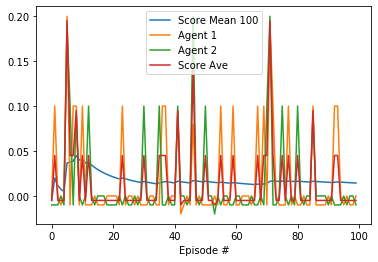

Episode 200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.011
Episode 200	Average Score: 0.01	Timestep: 4453

Batch Size: 4453


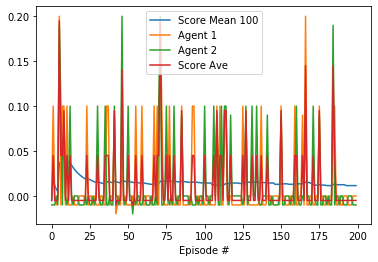

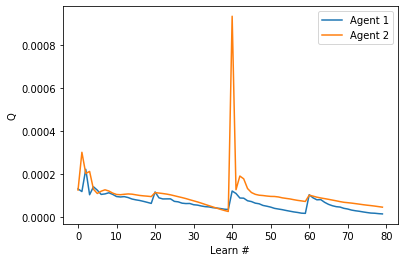

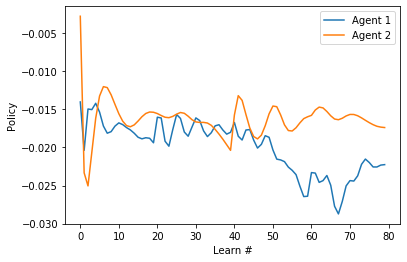

Episode 300(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 300	Average Score: -0.00	Timestep: 5983

Batch Size: 5983


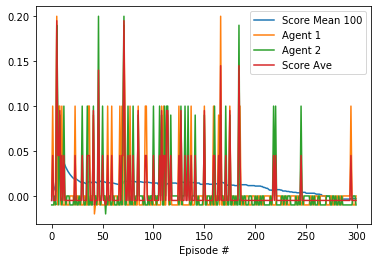

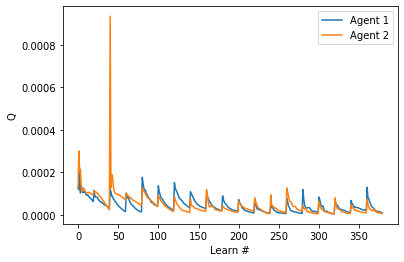

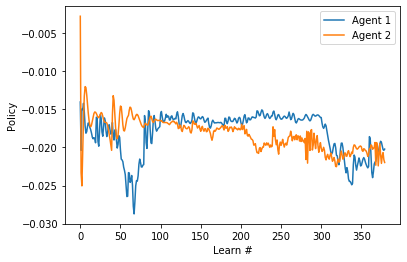

Episode 400(0sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:-0.0000
Episode 400	Average Score: -0.00	Timestep: 7435

Batch Size: 7435


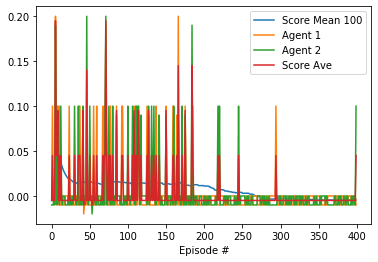

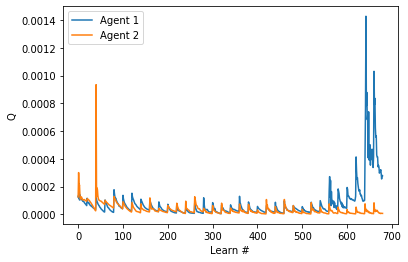

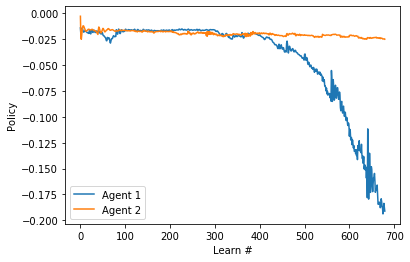

Episode 500(0sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:-0.0000
Episode 500	Average Score: -0.00	Timestep: 9032

Batch Size: 9032


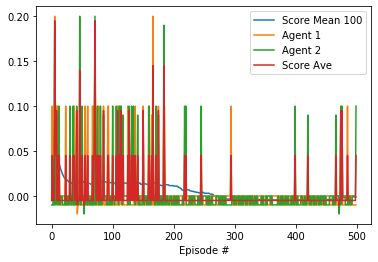

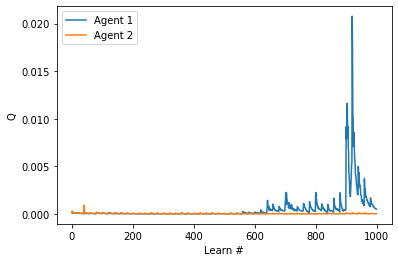

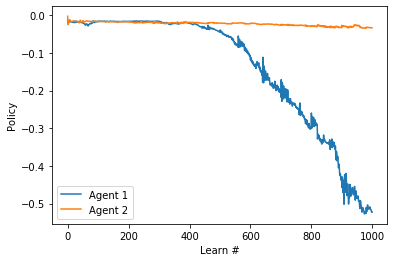

In [342]:
# benchmark
BUFFER_SIZE = 2 ** 14  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 100        # learning timestep interval
LEARN_NUM = 20          # number of learning passes
LEARN_AFTER = 4000
SEED=1

scores_ave, agent = train(n_episodes=500, random_seed=SEED)

In [374]:
# read model weights
best_agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
actor_state_dict_0 = torch.load('./experiment_1/actor0_500.pth', map_location='cpu')
actor_state_dict_1 = torch.load('./experiment_1/actor1_500.pth', map_location='cpu')
best_agent.actor_local[0].load_state_dict(actor_state_dict_0)
best_agent.actor_local[1].load_state_dict(actor_state_dict_1)

play(best_agent)

Score (sum over agents) from episode 0: -0.01
Score (sum over agents) from episode 1: -0.01
Score (sum over agents) from episode 2: 0.09
Score (sum over agents) from episode 3: -0.01
Score (sum over agents) from episode 4: 0.09
Score (sum over agents) from episode 5: 0.09
Score (sum over agents) from episode 6: 0.09
Score (sum over agents) from episode 7: -0.01
Score (sum over agents) from episode 8: 0.09
Score (sum over agents) from episode 9: -0.01


#### Experiment 2

Episode 100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.02
Episode 100	Average Score: 0.02	Timestep: 2353

Batch Size: 2353


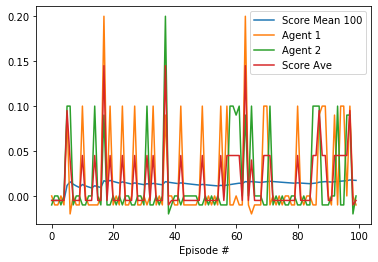

Episode 200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.011
Episode 200	Average Score: 0.01	Timestep: 4478

Batch Size: 4478


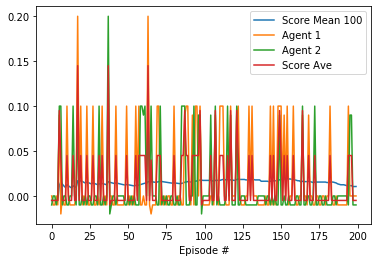

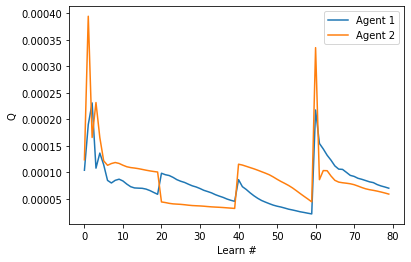

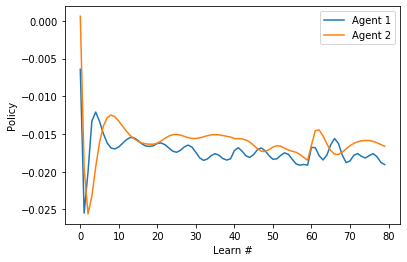

Episode 300(12sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 300	Average Score: -0.00	Timestep: 5914

Batch Size: 5914


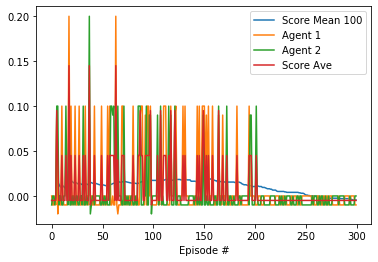

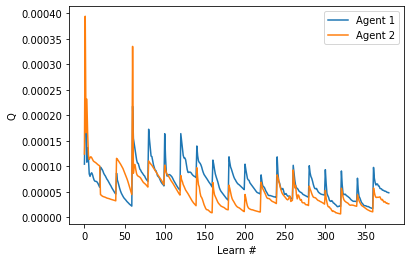

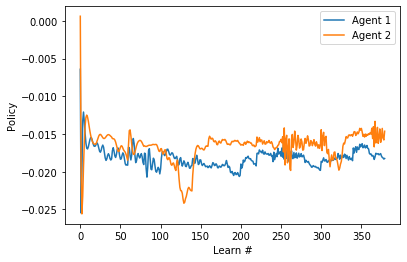

Episode 400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 400	Average Score: -0.00	Timestep: 7515

Batch Size: 7515


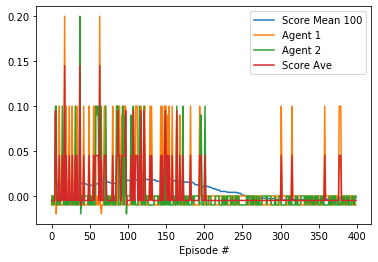

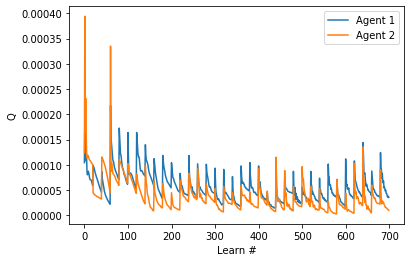

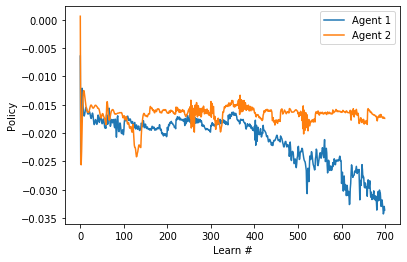

Episode 500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 500	Average Score: -0.00	Timestep: 8936

Batch Size: 8936


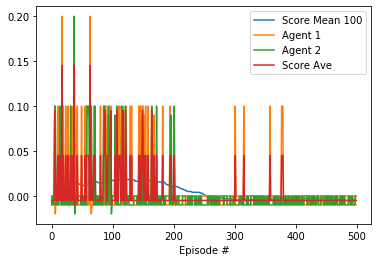

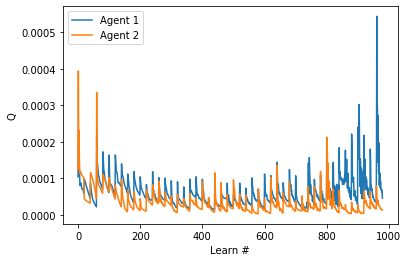

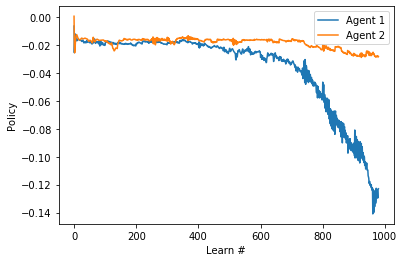

Episode 600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 600	Average Score: -0.00	Timestep: 10666

Batch Size: 10666


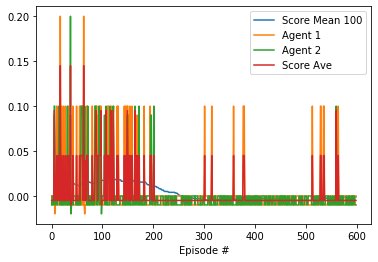

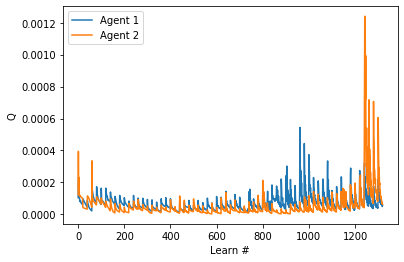

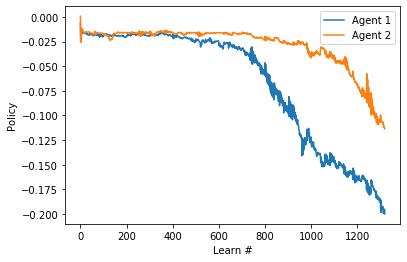

Episode 700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 700	Average Score: -0.00	Timestep: 12179

Batch Size: 12179


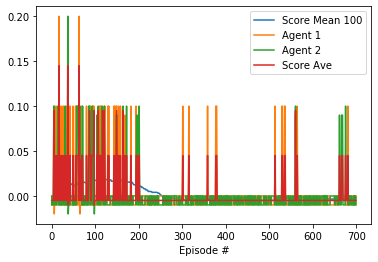

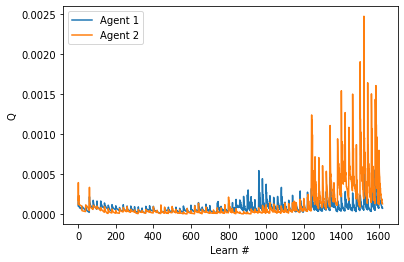

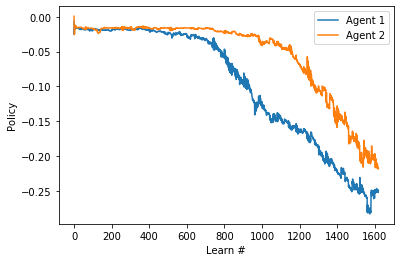

Episode 800(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.0000
Episode 800	Average Score: 0.00	Timestep: 13878

Batch Size: 13878


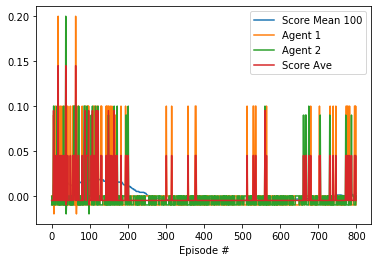

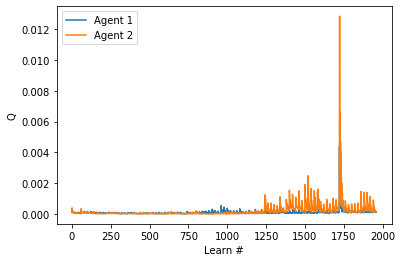

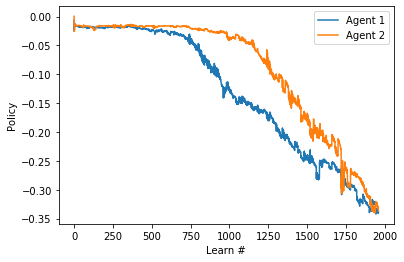

Episode 900(0sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.0111
Episode 900	Average Score: 0.01	Timestep: 15873

Batch Size: 15873


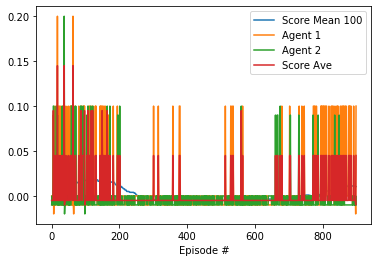

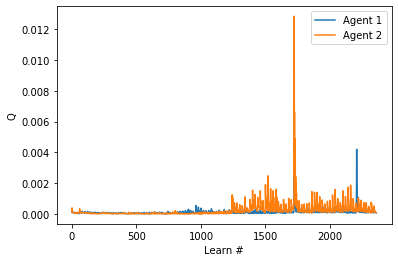

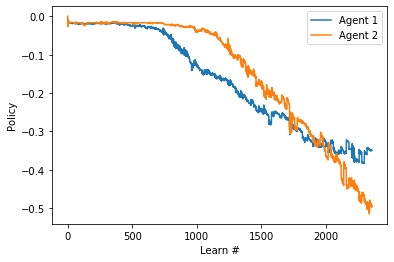

Episode 1000(0sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.021
Episode 1000	Average Score: 0.02	Timestep: 18073

Batch Size: 16384


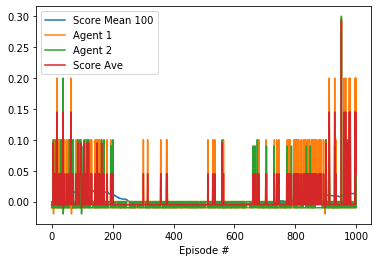

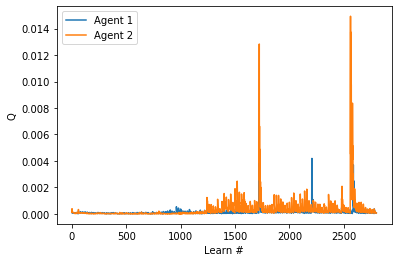

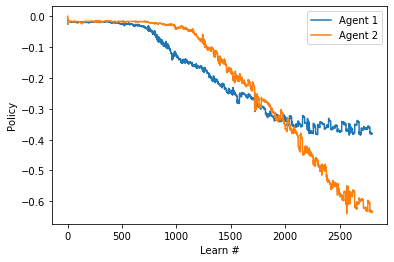

Episode 1100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1100	Average Score: -0.00	Timestep: 19665

Batch Size: 16384


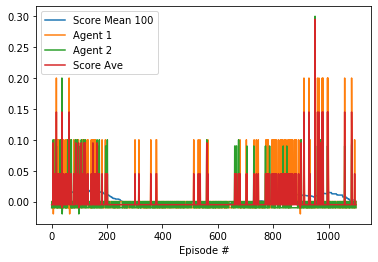

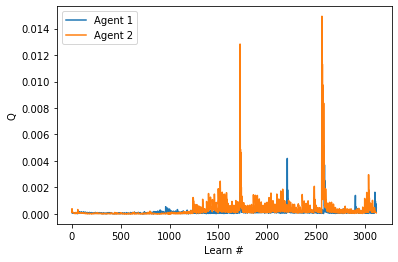

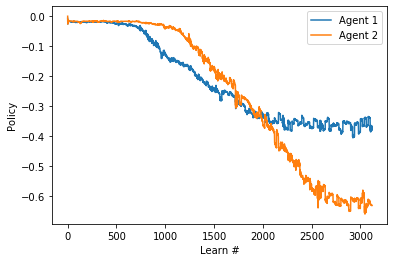

Episode 1200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.0000
Episode 1200	Average Score: 0.00	Timestep: 21343

Batch Size: 16384


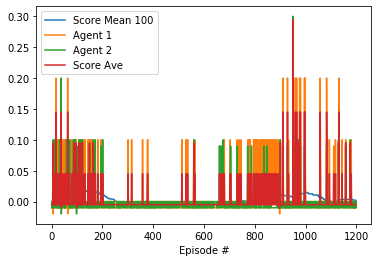

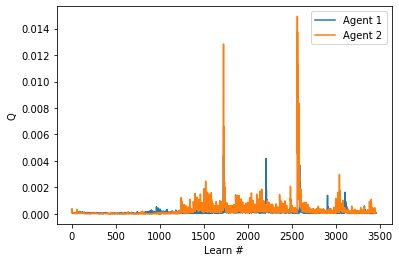

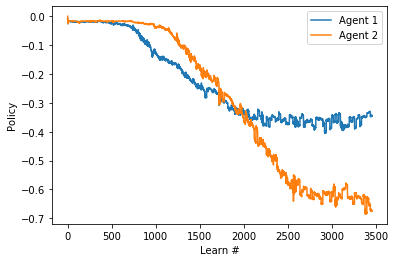

Episode 1300(11sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1300	Average Score: -0.00	Timestep: 22802

Batch Size: 16384


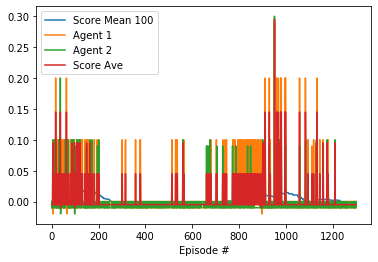

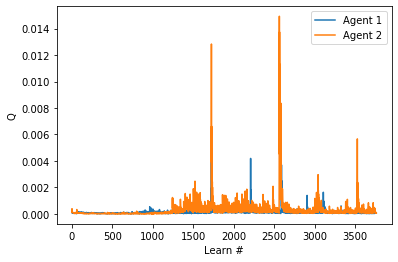

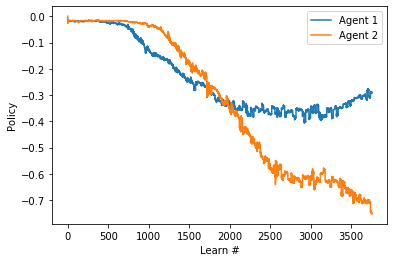

Episode 1400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 1400	Average Score: -0.00	Timestep: 24222

Batch Size: 16384


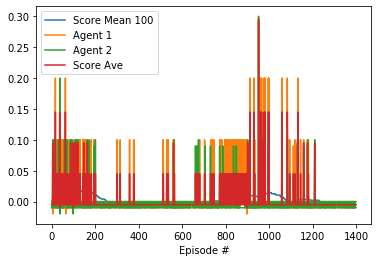

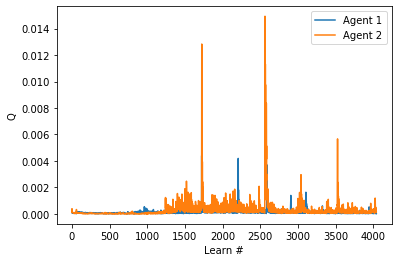

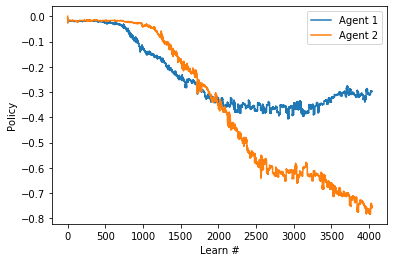

Episode 1500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 1500	Average Score: -0.00	Timestep: 25641

Batch Size: 16384


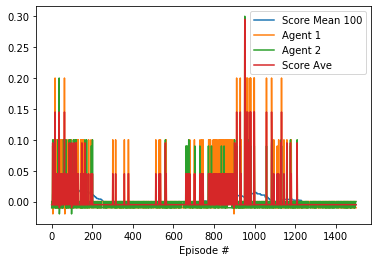

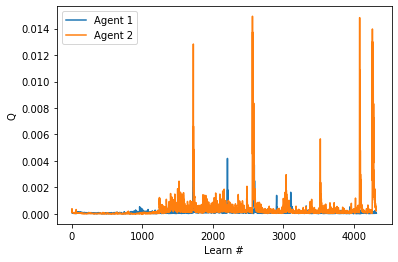

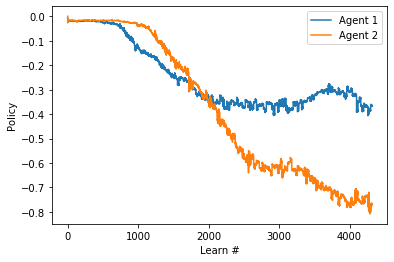

Episode 1600(11sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.0000
Episode 1600	Average Score: 0.00	Timestep: 27305

Batch Size: 16384


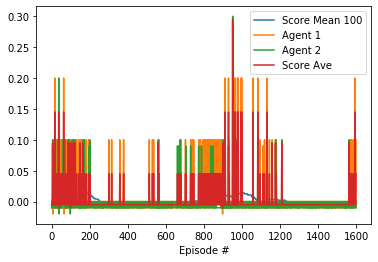

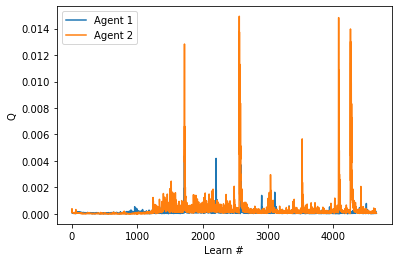

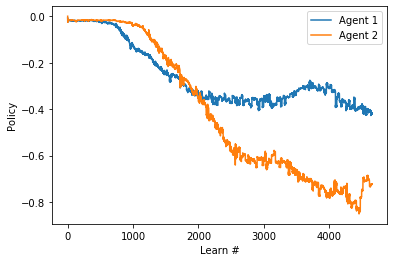

Episode 1700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.011
Episode 1700	Average Score: 0.01	Timestep: 29267

Batch Size: 16384


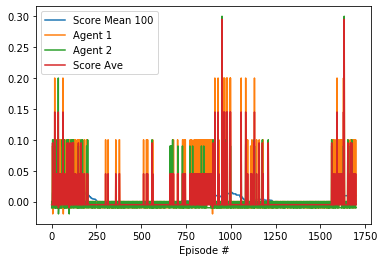

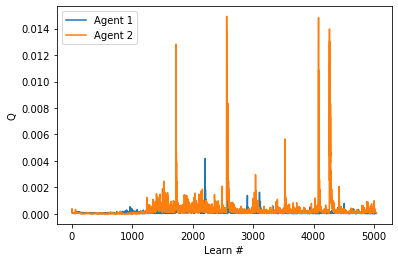

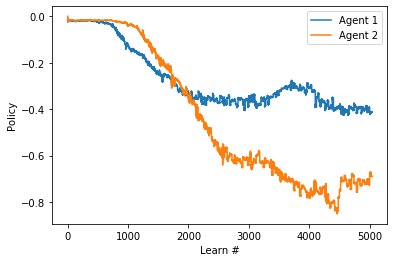

Episode 1800(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.011
Episode 1800	Average Score: 0.01	Timestep: 31287

Batch Size: 16384


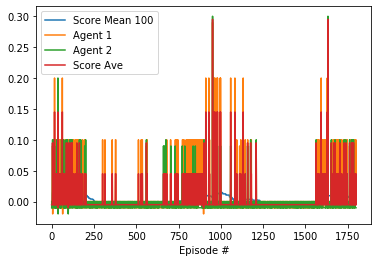

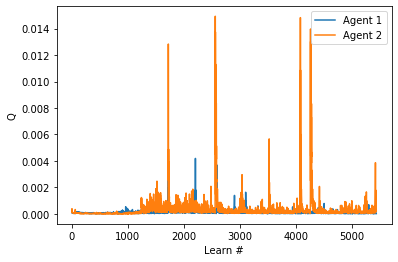

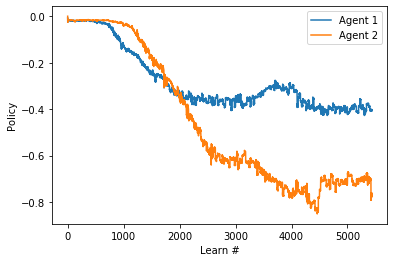

Episode 1900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.000
Episode 1900	Average Score: 0.00	Timestep: 33060

Batch Size: 16384


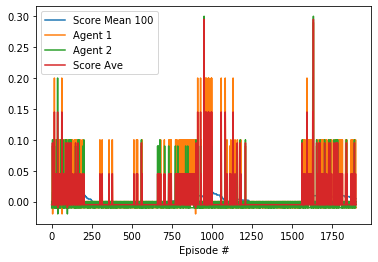

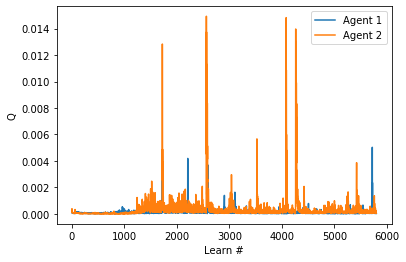

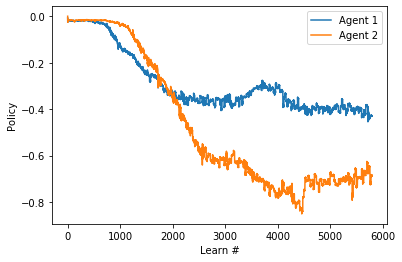

Episode 2000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2000	Average Score: -0.00	Timestep: 34535

Batch Size: 16384


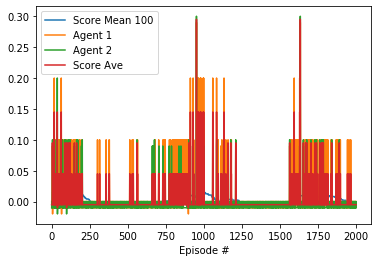

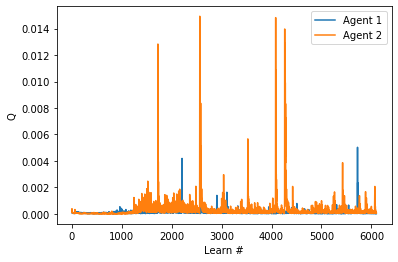

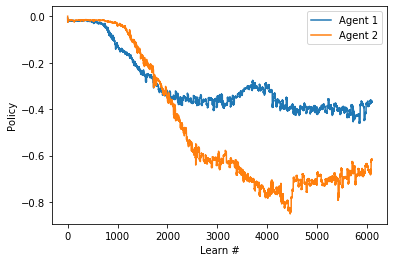

Episode 2100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2100	Average Score: -0.00	Timestep: 35955

Batch Size: 16384


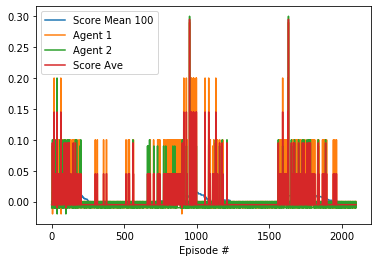

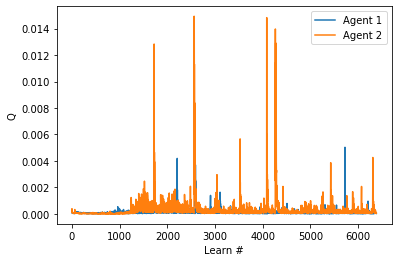

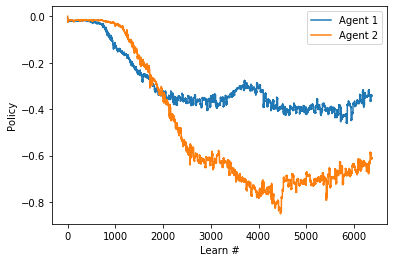

Episode 2200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2200	Average Score: -0.00	Timestep: 37375

Batch Size: 16384


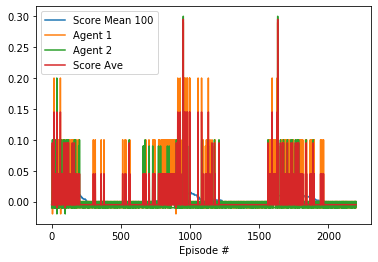

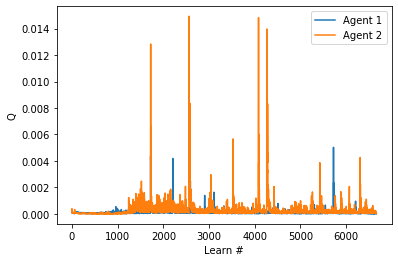

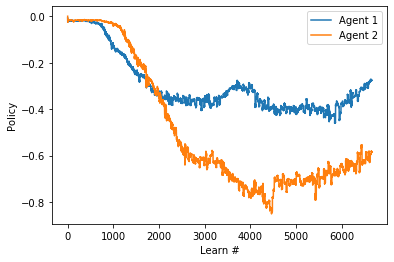

Episode 2300(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2300	Average Score: -0.00	Timestep: 38931

Batch Size: 16384


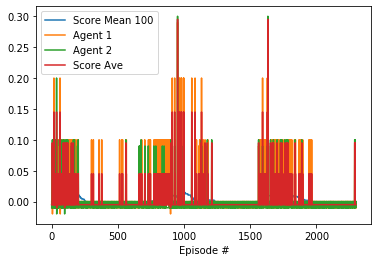

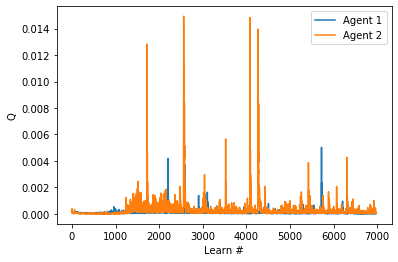

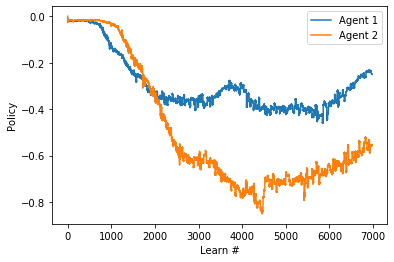

Episode 2400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2400	Average Score: -0.00	Timestep: 40351

Batch Size: 16384


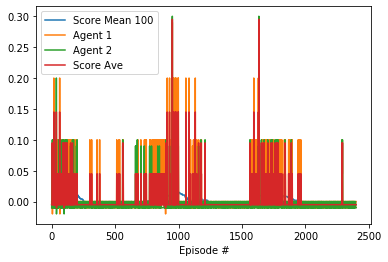

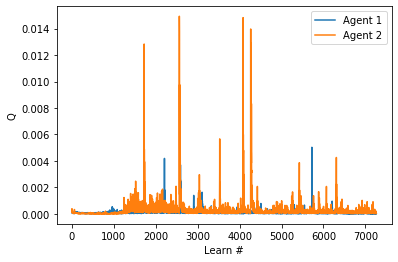

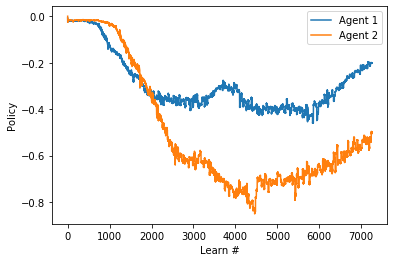

Episode 2500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2500	Average Score: -0.00	Timestep: 41771

Batch Size: 16384


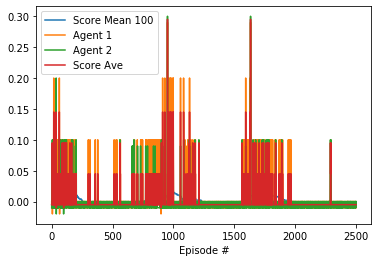

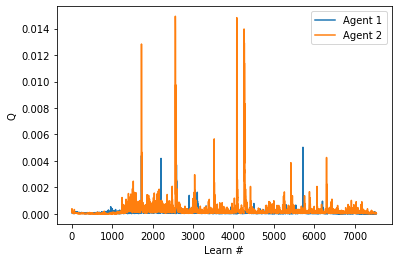

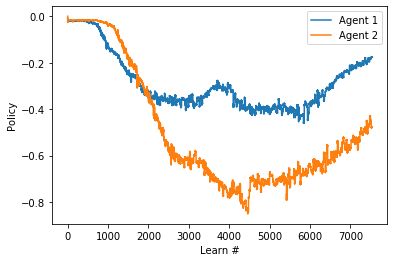

Episode 2600(1sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2600	Average Score: -0.00	Timestep: 43191

Batch Size: 16384


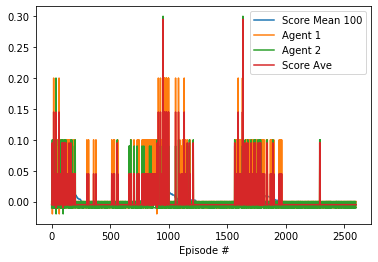

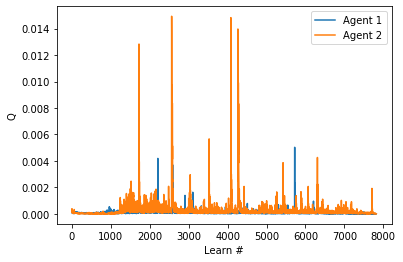

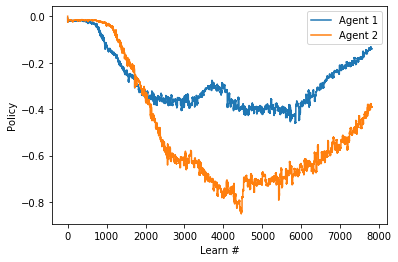

Episode 2700(16sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2700	Average Score: -0.00	Timestep: 44611

Batch Size: 16384


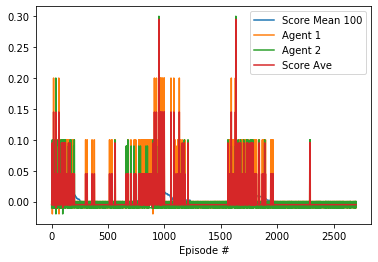

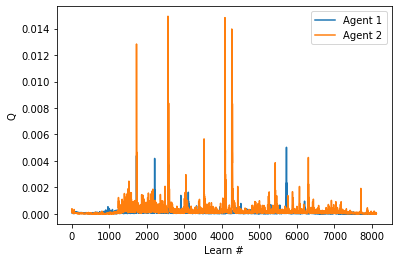

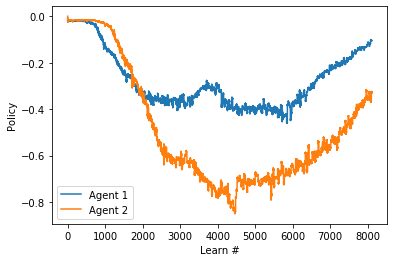

Episode 2800(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2800	Average Score: -0.00	Timestep: 46031

Batch Size: 16384


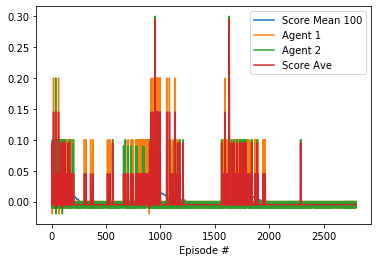

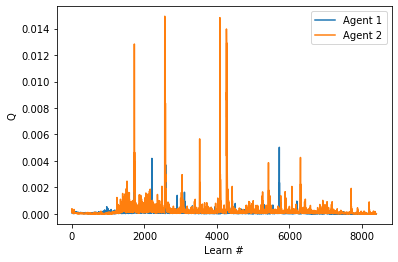

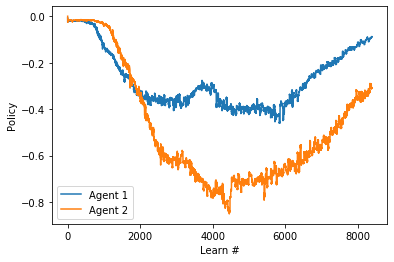

Episode 2900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2900	Average Score: -0.00	Timestep: 47451

Batch Size: 16384


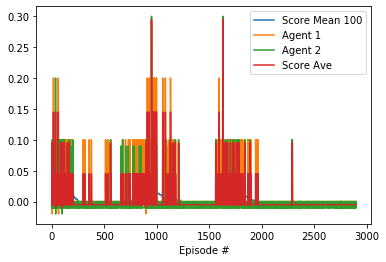

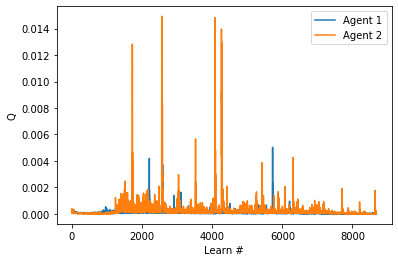

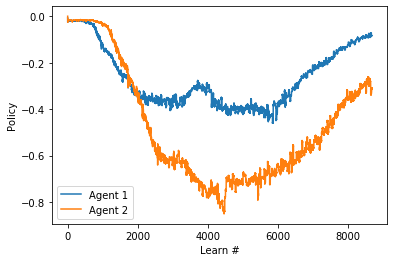

Episode 3000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.0000
Episode 3000	Average Score: 0.00	Timestep: 49089

Batch Size: 16384


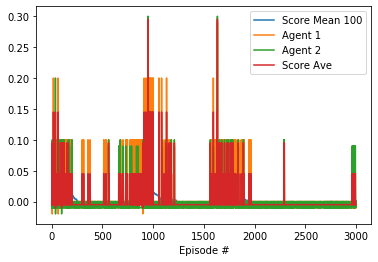

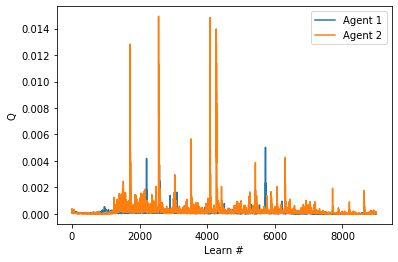

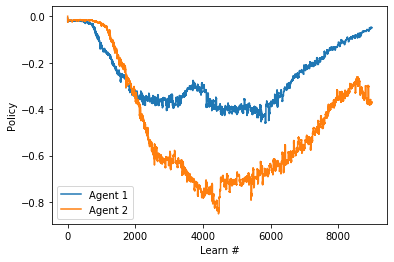

In [379]:
# benchmark
BUFFER_SIZE = 2 ** 14  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 100        # learning timestep interval
LEARN_NUM = 20          # number of learning passes
LEARN_AFTER = 4000
SEED=1

scores_ave, agent = train(n_episodes=3000, random_seed=SEED)

In [407]:
# read model weights
best_agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
actor_state_dict_0 = torch.load('./experiment_2/actor0_1600.pth', map_location='cpu')
actor_state_dict_1 = torch.load('./experiment_2/actor1_3000.pth', map_location='cpu')
best_agent.actor_local[0].load_state_dict(actor_state_dict_0)
best_agent.actor_local[1].load_state_dict(actor_state_dict_1)

play(best_agent)

Score (sum over agents) from episode 0: 0.19
Score (sum over agents) from episode 1: 0.09
Score (sum over agents) from episode 2: 0.09
Score (sum over agents) from episode 3: -0.01
Score (sum over agents) from episode 4: 0.19
Score (sum over agents) from episode 5: 0.09
Score (sum over agents) from episode 6: 0.19
Score (sum over agents) from episode 7: -0.01
Score (sum over agents) from episode 8: 0.09
Score (sum over agents) from episode 9: 0.09


#### Experiment 3

Episode 100(1sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.03
Episode 100	Average Score: 0.03	Timestep: 2869

Batch Size: 2869


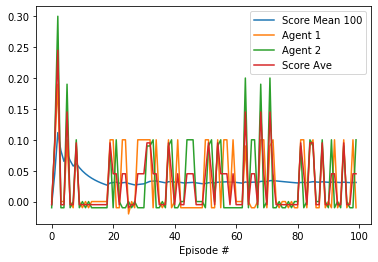

Episode 200(0sec)	 MIN:-0.01 MAX:0.10 MEAN:0.05 MEANo100:0.044
Episode 200	Average Score: 0.04	Timestep: 5943

Batch Size: 5943


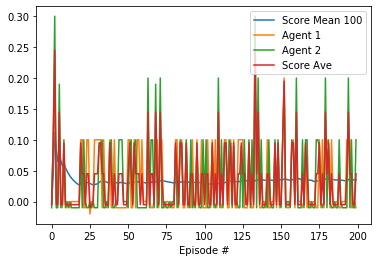

Episode 300(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:0.002
Episode 300	Average Score: 0.00	Timestep: 7696

Batch Size: 7696


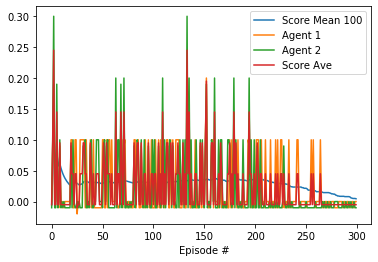

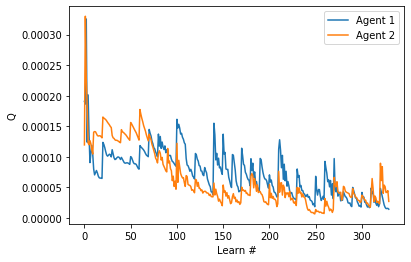

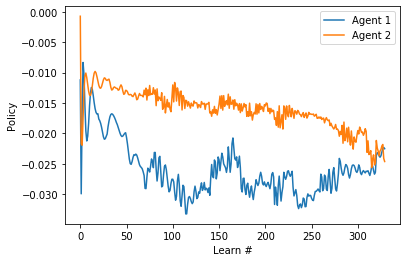

Episode 400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 400	Average Score: -0.00	Timestep: 9133

Batch Size: 9133


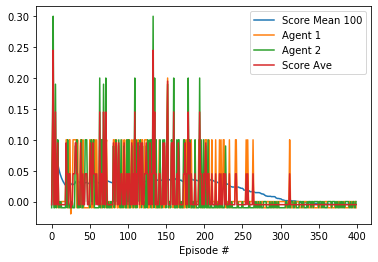

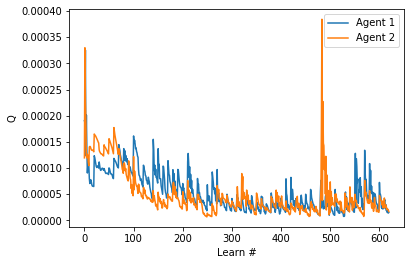

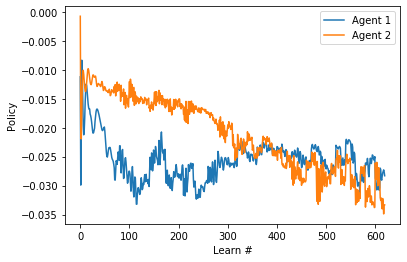

Episode 500(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 500	Average Score: -0.00	Timestep: 10553

Batch Size: 10553


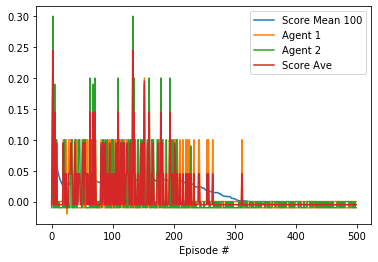

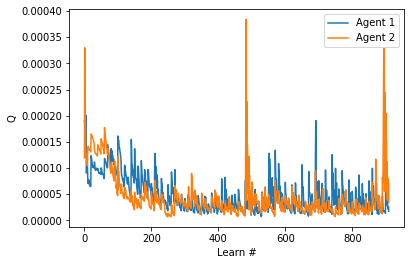

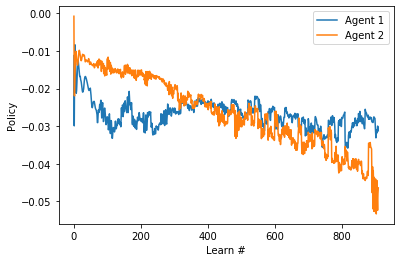

Episode 600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 600	Average Score: -0.00	Timestep: 11973

Batch Size: 11973


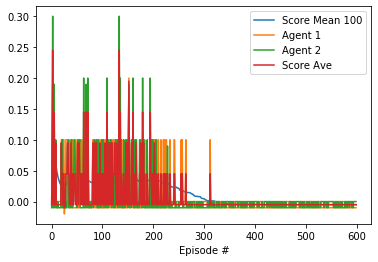

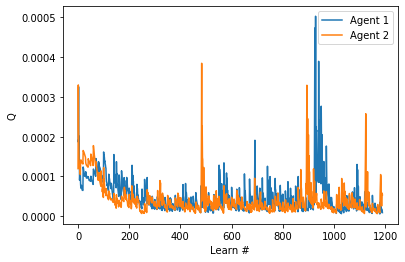

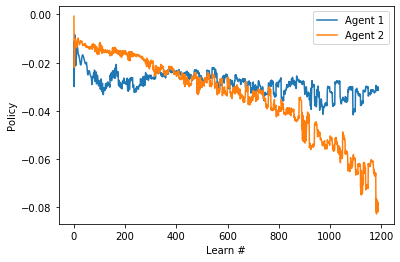

Episode 700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 700	Average Score: -0.00	Timestep: 13394

Batch Size: 13394


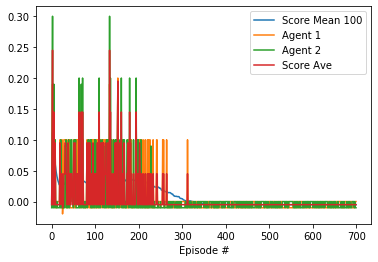

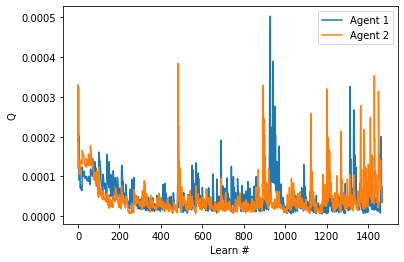

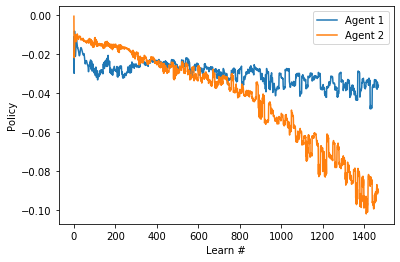

Episode 800(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 800	Average Score: -0.00	Timestep: 14814

Batch Size: 14814


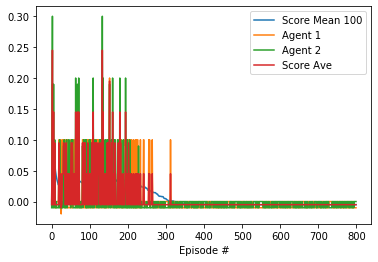

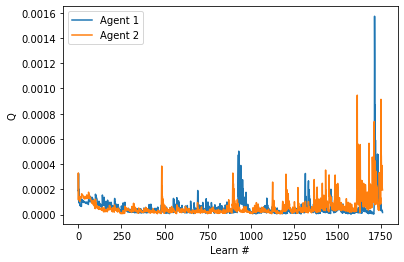

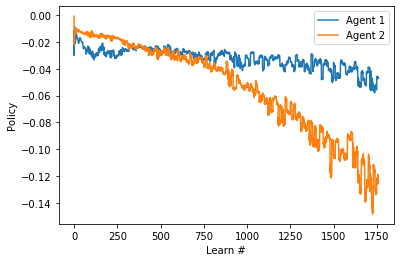

Episode 900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 900	Average Score: -0.00	Timestep: 16234

Batch Size: 16234


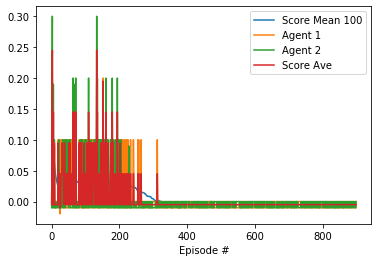

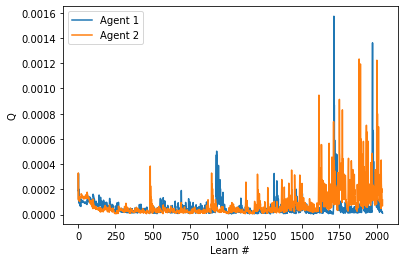

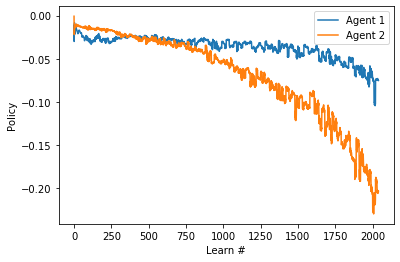

Episode 1000(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1000	Average Score: -0.00	Timestep: 17654

Batch Size: 16384


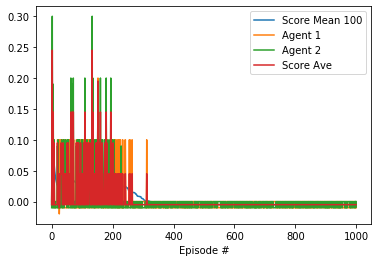

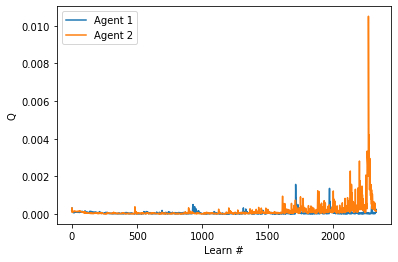

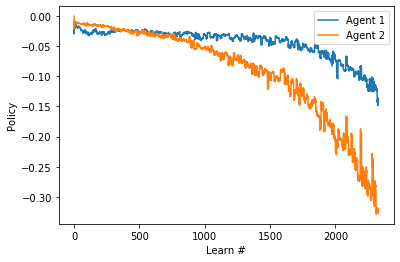

Episode 1100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1100	Average Score: -0.00	Timestep: 19074

Batch Size: 16384


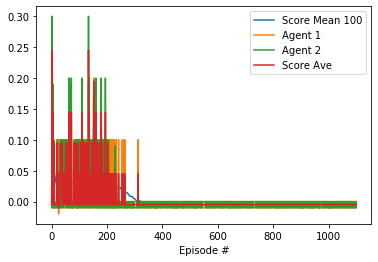

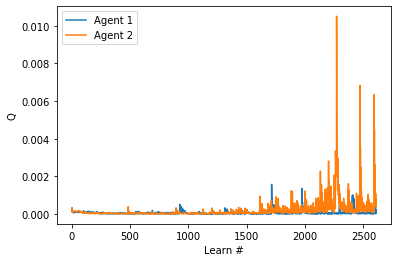

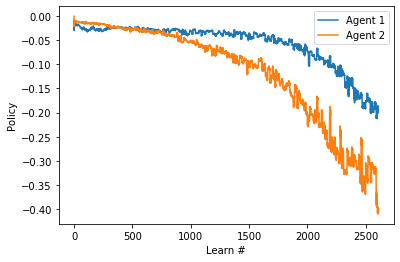

Episode 1200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1200	Average Score: -0.00	Timestep: 20494

Batch Size: 16384


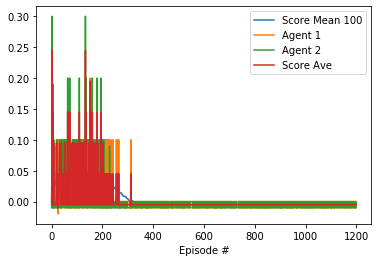

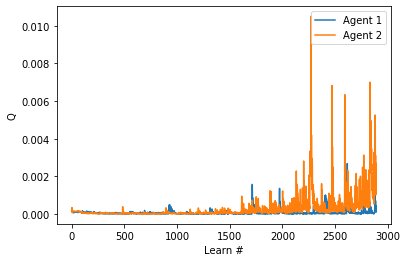

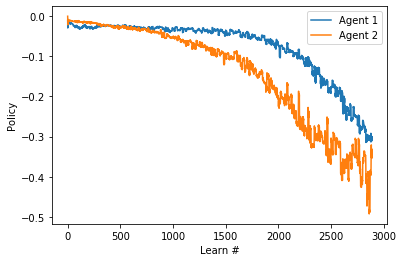

Episode 1300(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1300	Average Score: -0.00	Timestep: 21914

Batch Size: 16384


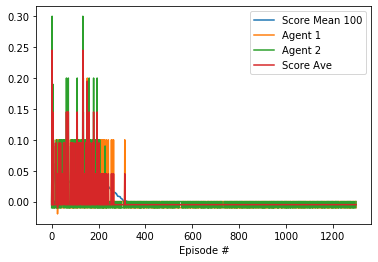

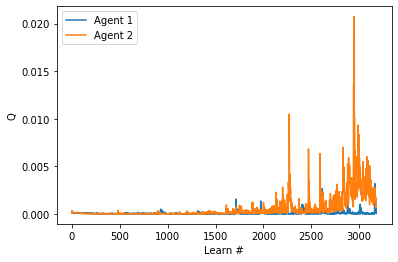

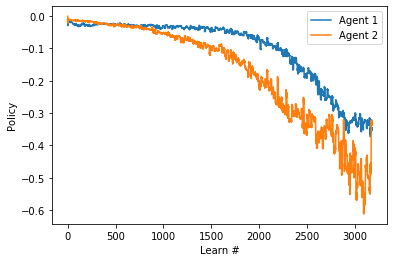

Episode 1400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1400	Average Score: -0.00	Timestep: 23334

Batch Size: 16384


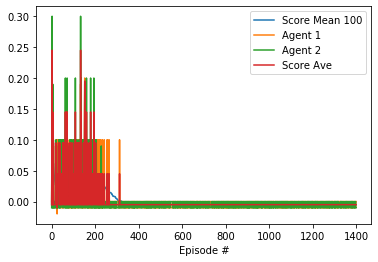

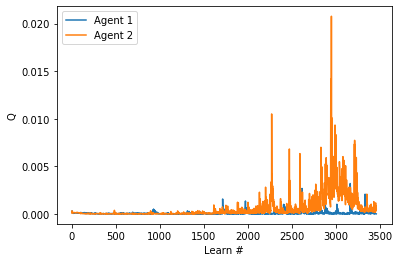

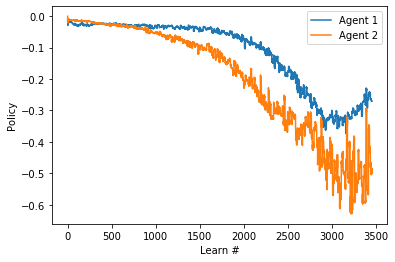

Episode 1500(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1500	Average Score: -0.00	Timestep: 24754

Batch Size: 16384


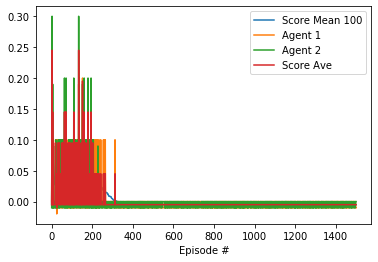

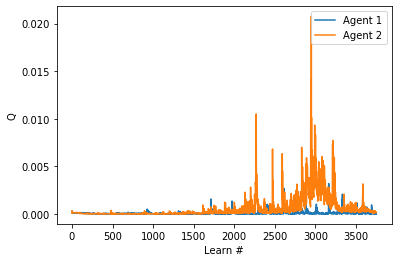

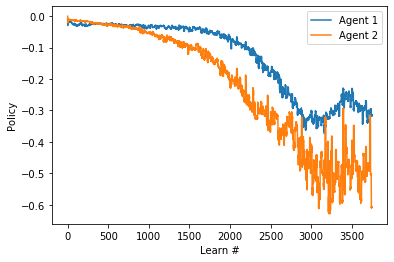

Episode 1600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1600	Average Score: -0.00	Timestep: 26174

Batch Size: 16384


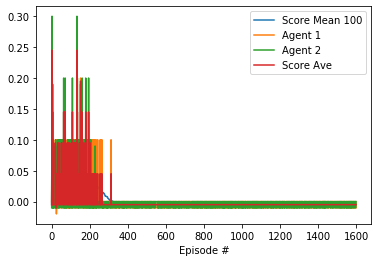

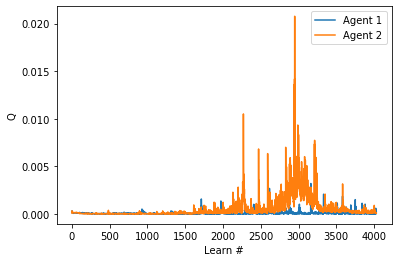

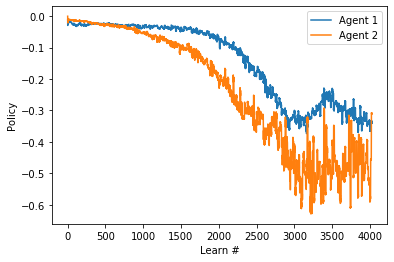

Episode 1700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1700	Average Score: -0.00	Timestep: 27594

Batch Size: 16384


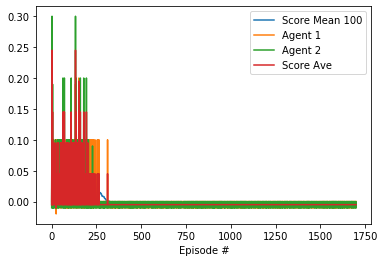

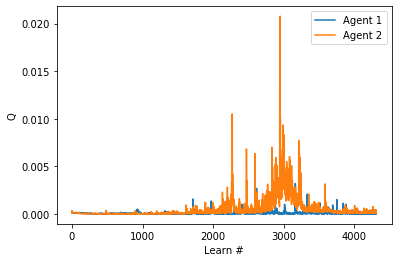

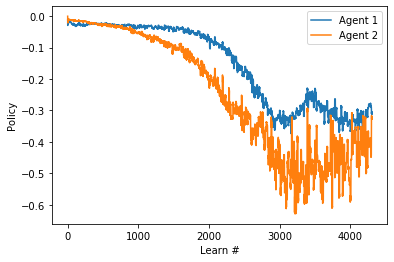

Episode 1800(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 1800	Average Score: -0.00	Timestep: 29014

Batch Size: 16384


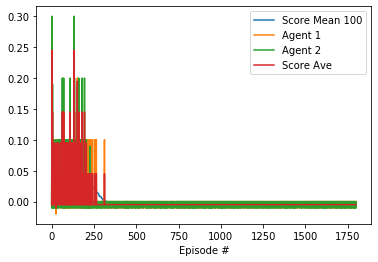

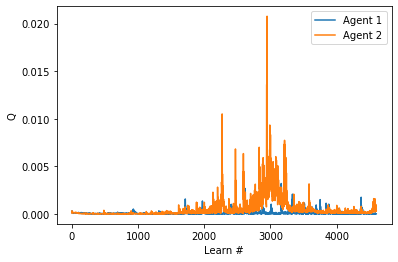

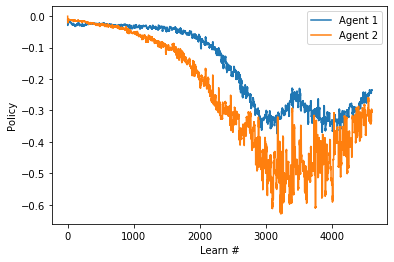

Episode 1900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 1900	Average Score: -0.00	Timestep: 30434

Batch Size: 16384


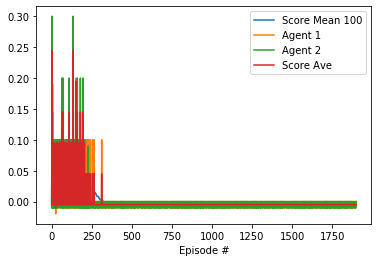

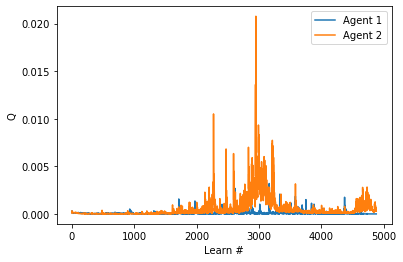

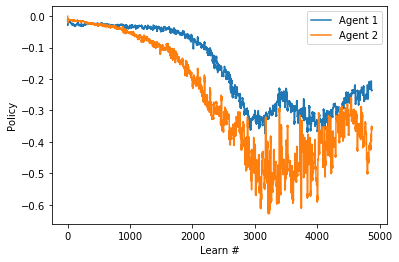

Episode 2000(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2000	Average Score: -0.00	Timestep: 31854

Batch Size: 16384


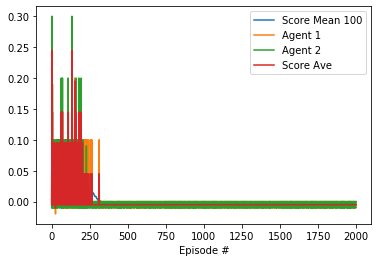

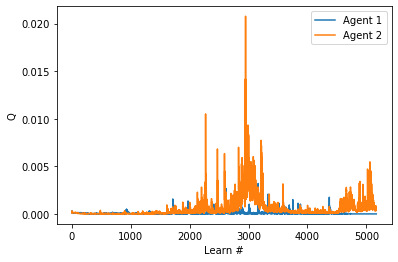

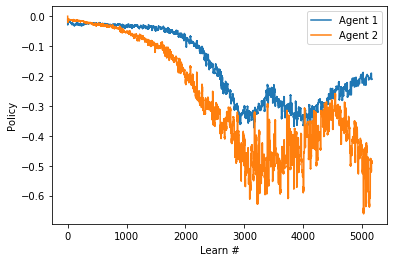

Episode 2100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2100	Average Score: -0.00	Timestep: 33274

Batch Size: 16384


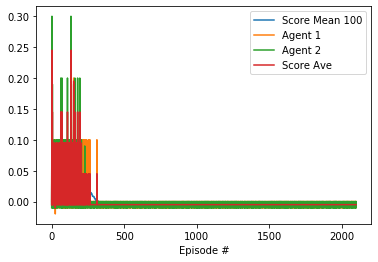

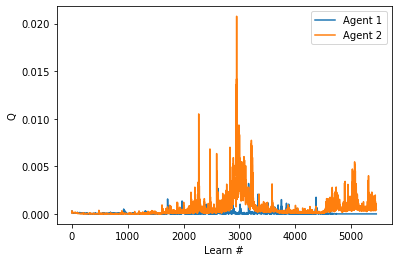

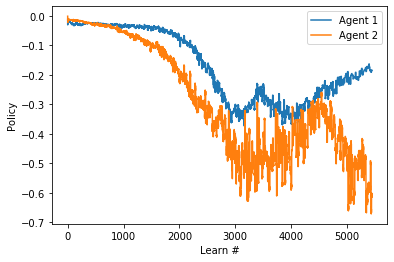

Episode 2200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2200	Average Score: -0.00	Timestep: 34694

Batch Size: 16384


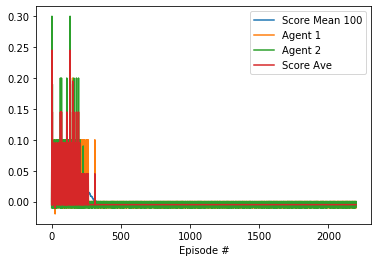

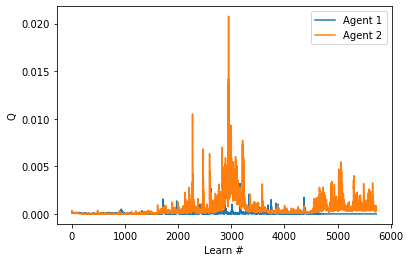

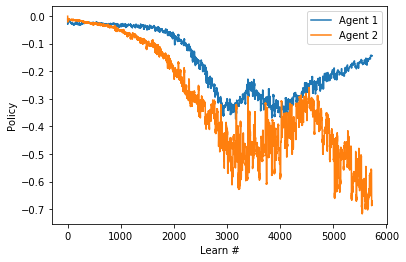

Episode 2300(1sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2300	Average Score: -0.00	Timestep: 36147

Batch Size: 16384


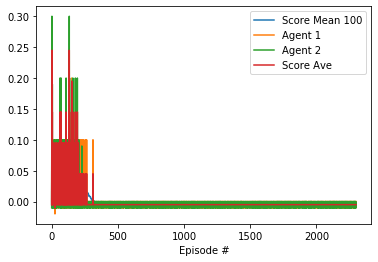

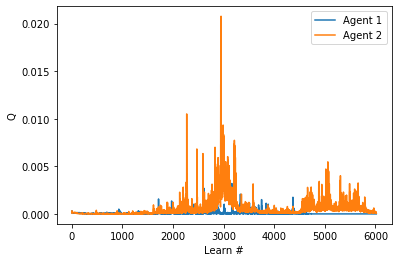

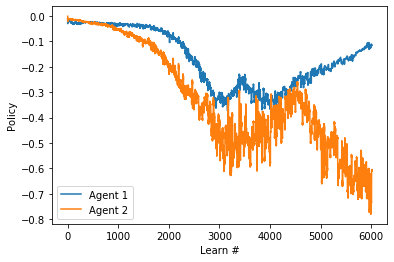

Episode 2400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 2400	Average Score: -0.00	Timestep: 37576

Batch Size: 16384


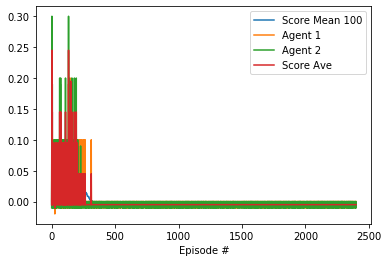

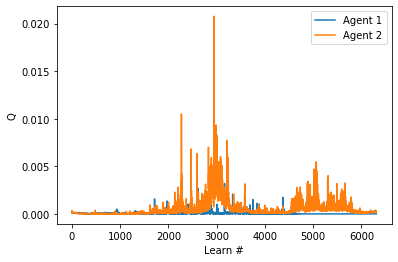

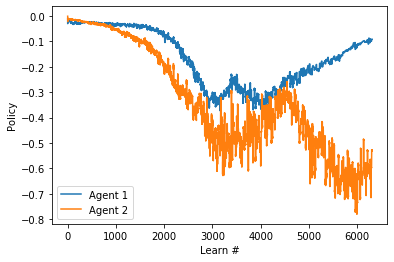

Episode 2500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2500	Average Score: -0.00	Timestep: 38996

Batch Size: 16384


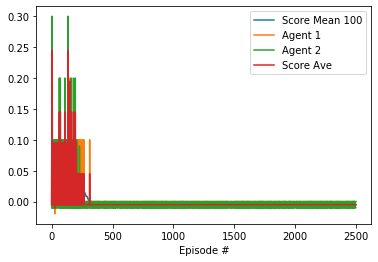

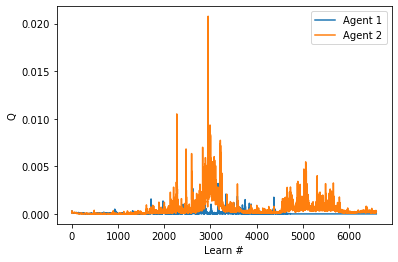

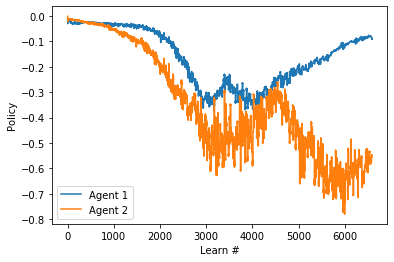

Episode 2600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2600	Average Score: -0.00	Timestep: 40416

Batch Size: 16384


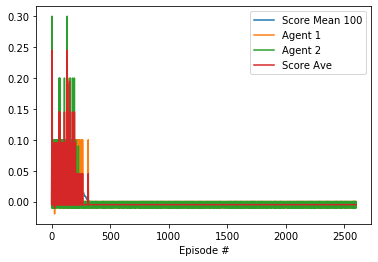

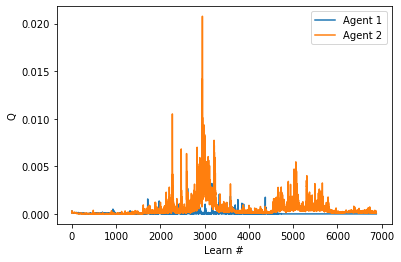

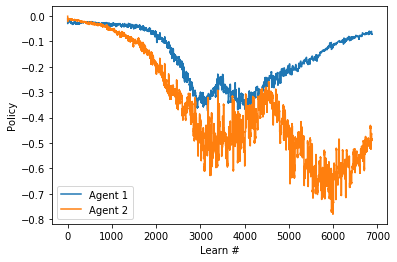

Episode 2700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2700	Average Score: -0.00	Timestep: 41836

Batch Size: 16384


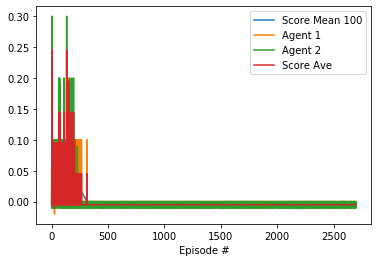

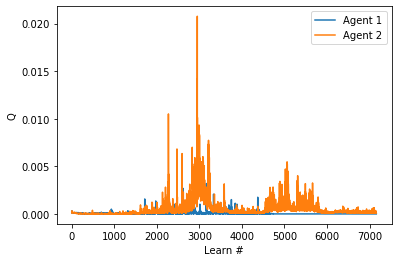

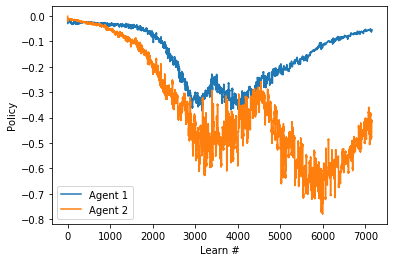

Episode 2800(8sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2800	Average Score: -0.00	Timestep: 43256

Batch Size: 16384


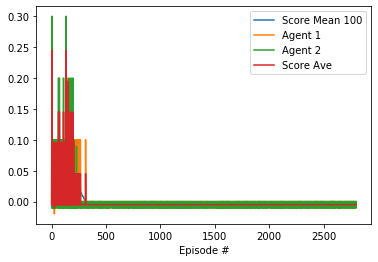

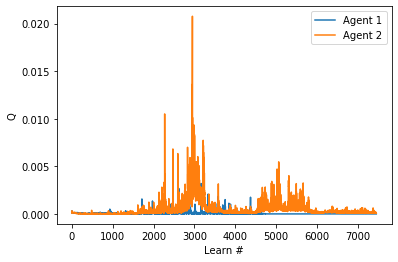

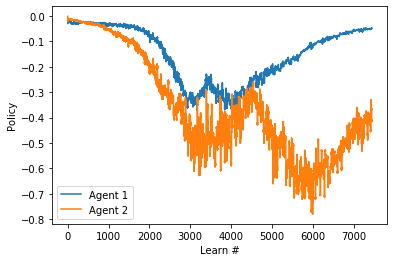

Episode 2900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 2900	Average Score: -0.00	Timestep: 44676

Batch Size: 16384


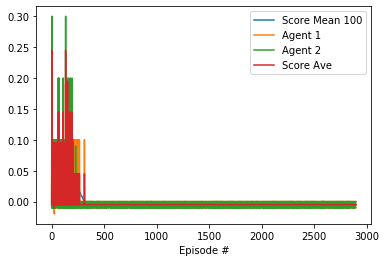

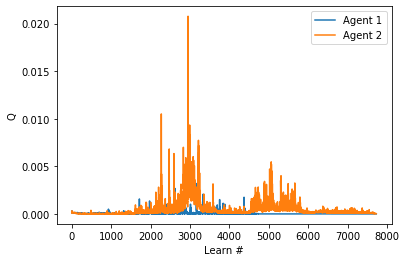

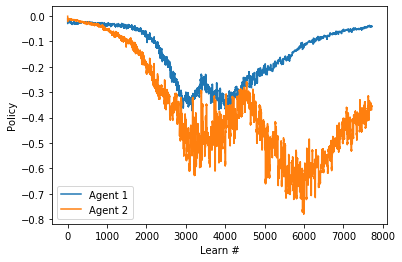

Episode 3000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3000	Average Score: -0.00	Timestep: 46096

Batch Size: 16384


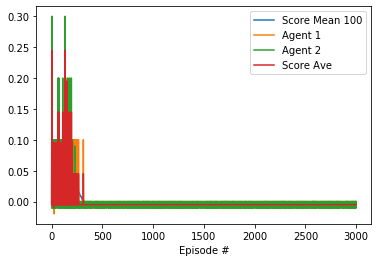

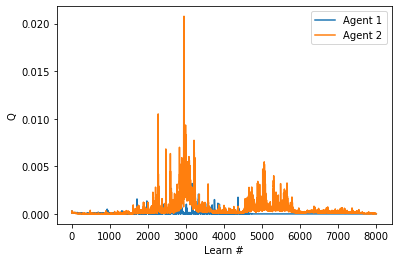

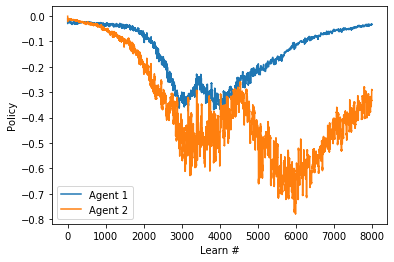

Episode 3100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3100	Average Score: -0.00	Timestep: 47516

Batch Size: 16384


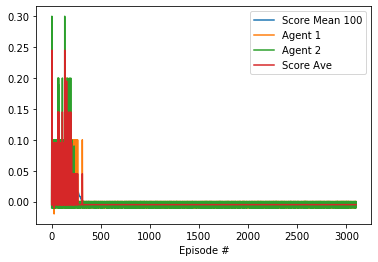

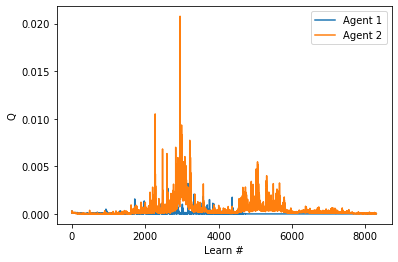

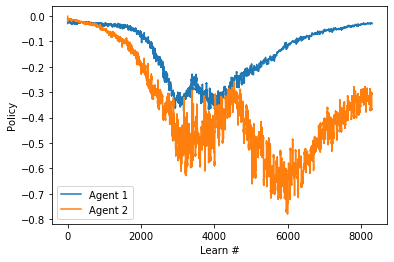

Episode 3200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3200	Average Score: -0.00	Timestep: 48936

Batch Size: 16384


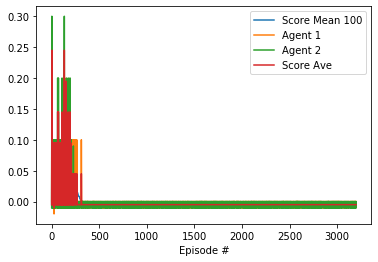

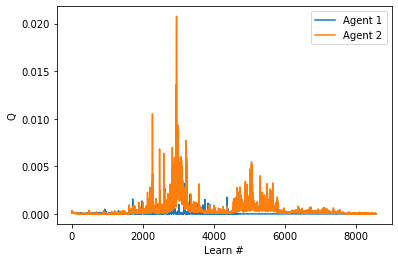

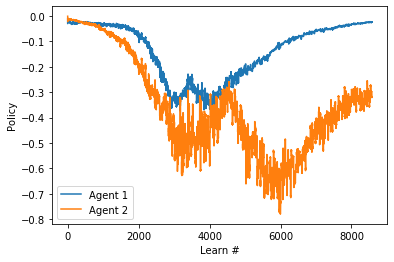

Episode 3300(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3300	Average Score: -0.00	Timestep: 50356

Batch Size: 16384


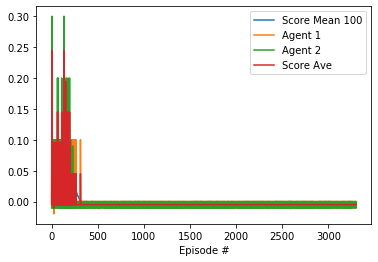

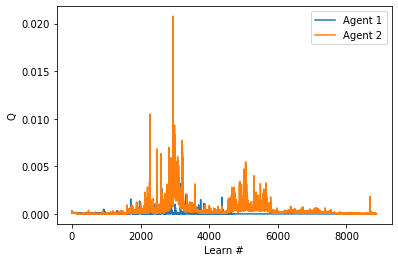

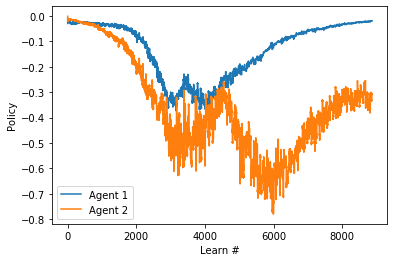

Episode 3400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3400	Average Score: -0.00	Timestep: 51776

Batch Size: 16384


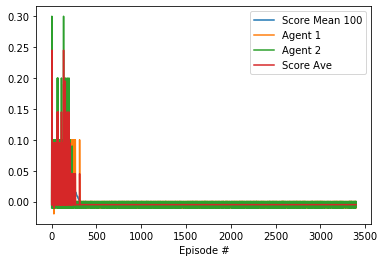

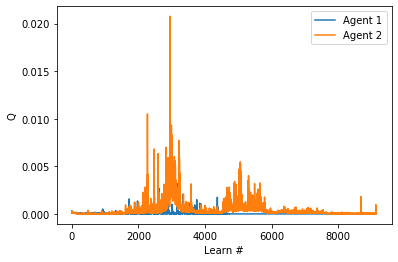

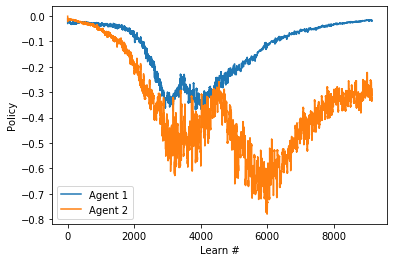

Episode 3500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3500	Average Score: -0.00	Timestep: 53196

Batch Size: 16384


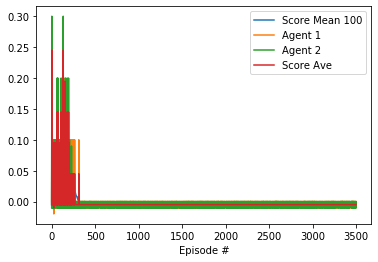

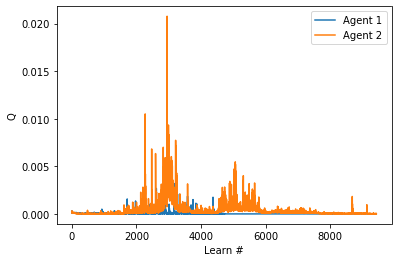

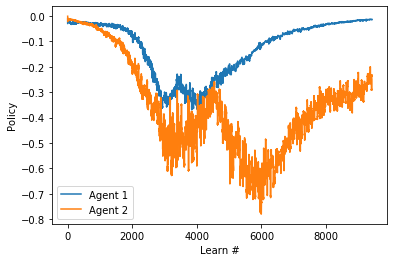

Episode 3600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 3600	Average Score: -0.00	Timestep: 54616

Batch Size: 16384


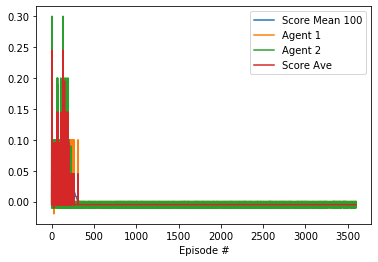

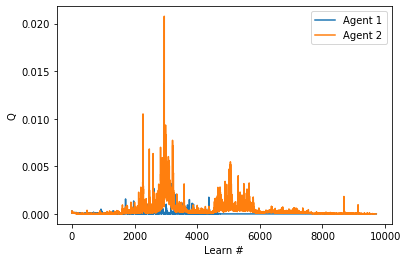

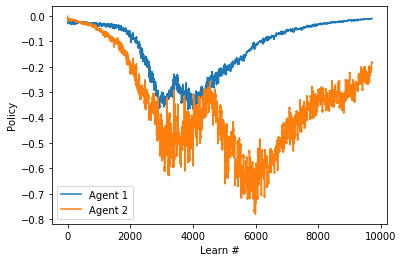

Episode 3700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3700	Average Score: -0.00	Timestep: 56036

Batch Size: 16384


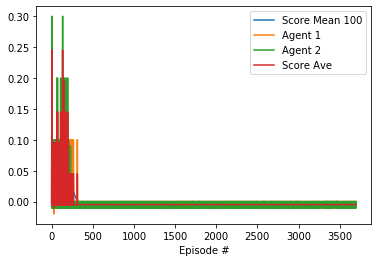

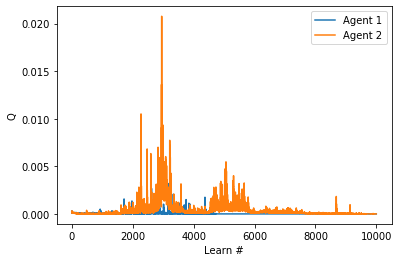

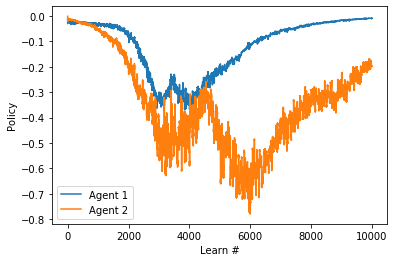

Episode 3800(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3800	Average Score: -0.00	Timestep: 57456

Batch Size: 16384


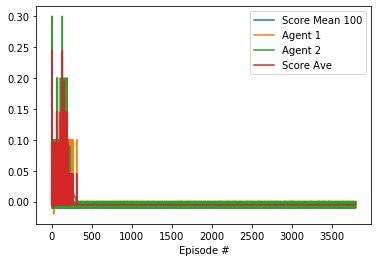

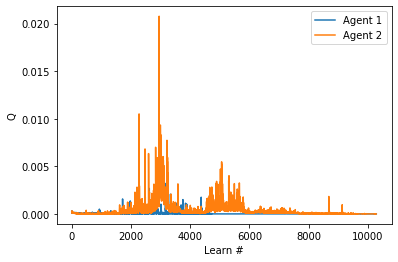

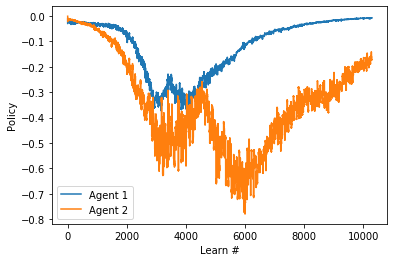

Episode 3900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 3900	Average Score: -0.00	Timestep: 58876

Batch Size: 16384


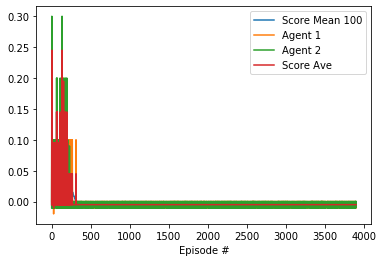

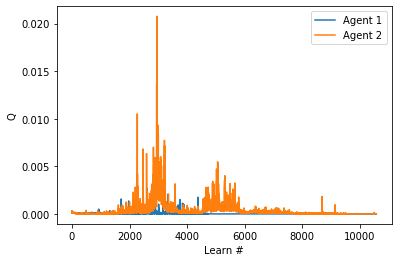

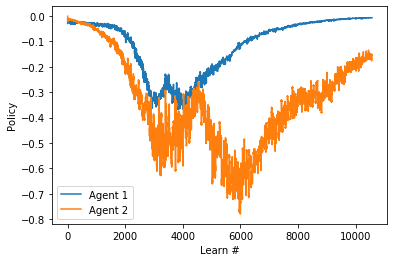

Episode 4000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4000	Average Score: -0.00	Timestep: 60296

Batch Size: 16384


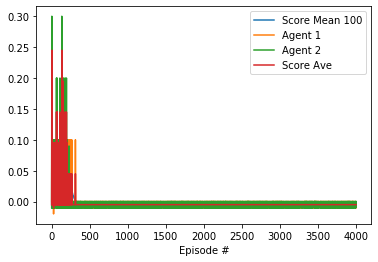

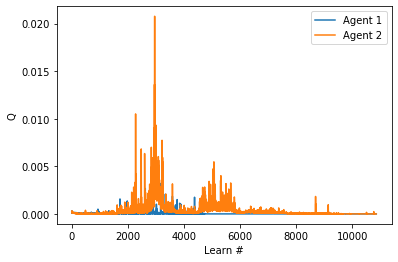

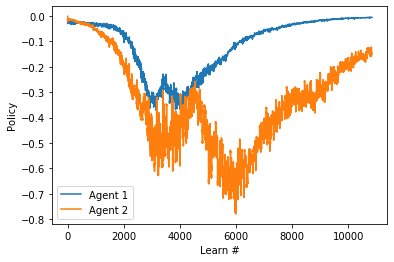

Episode 4100(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.000
Episode 4100	Average Score: -0.00	Timestep: 61716

Batch Size: 16384


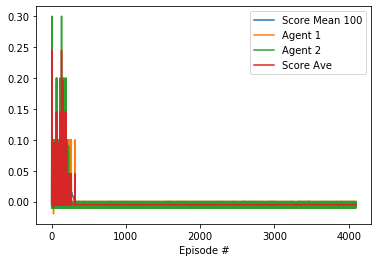

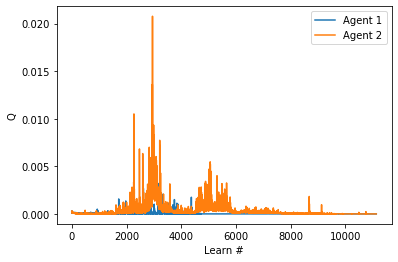

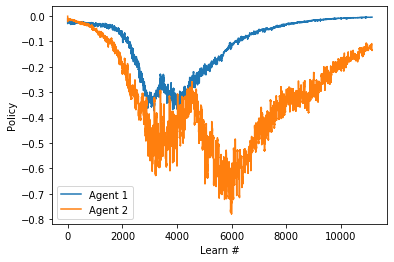

Episode 4200(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4200	Average Score: -0.00	Timestep: 63136

Batch Size: 16384


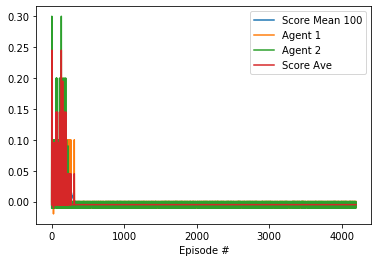

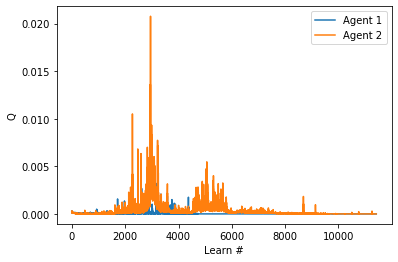

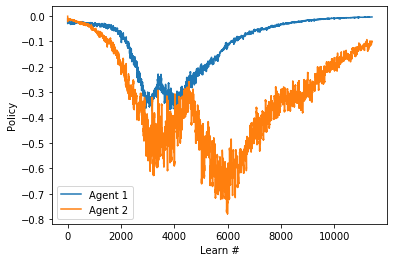

Episode 4300(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4300	Average Score: -0.00	Timestep: 64556

Batch Size: 16384


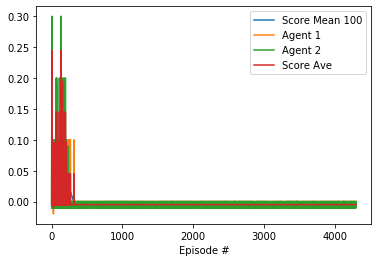

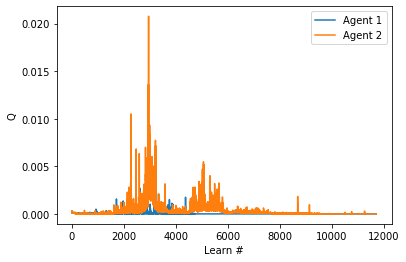

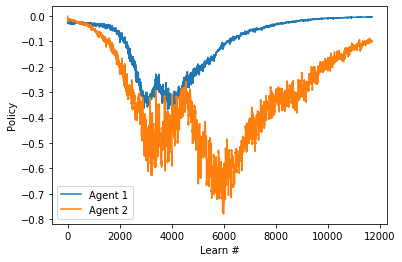

Episode 4400(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4400	Average Score: -0.00	Timestep: 65976

Batch Size: 16384


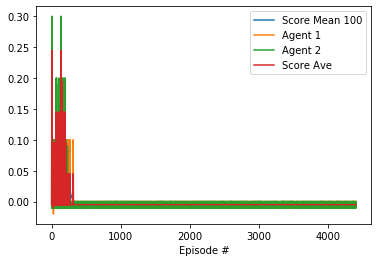

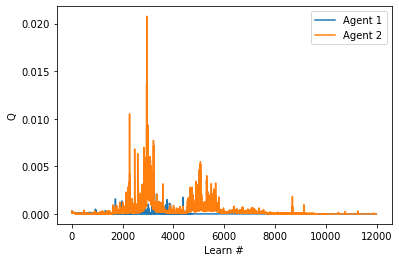

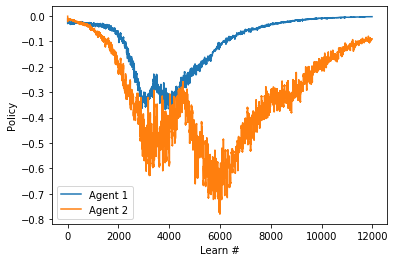

Episode 4500(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4500	Average Score: -0.00	Timestep: 67396

Batch Size: 16384


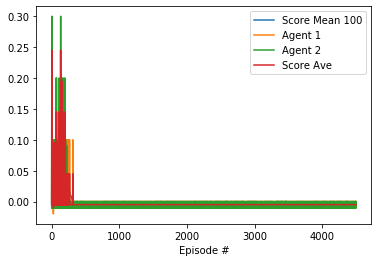

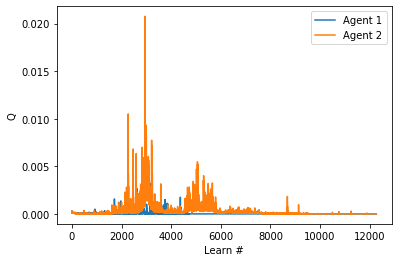

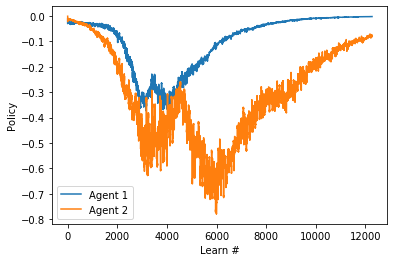

Episode 4600(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4600	Average Score: -0.00	Timestep: 68867

Batch Size: 16384


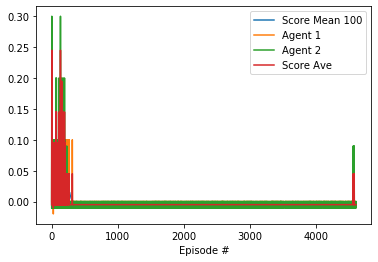

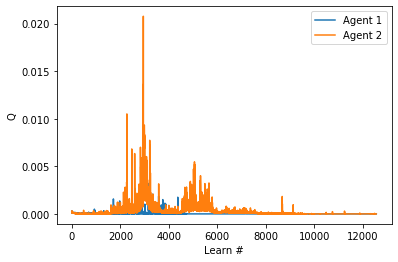

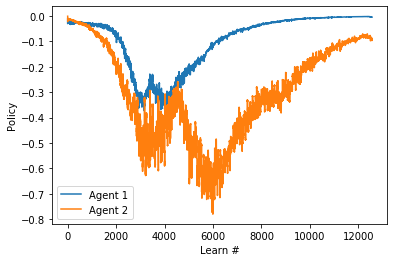

Episode 4700(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4700	Average Score: -0.00	Timestep: 70287

Batch Size: 16384


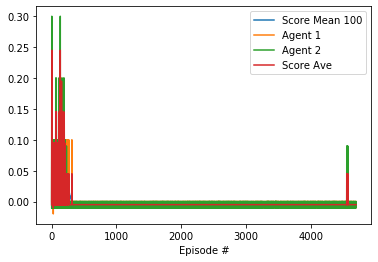

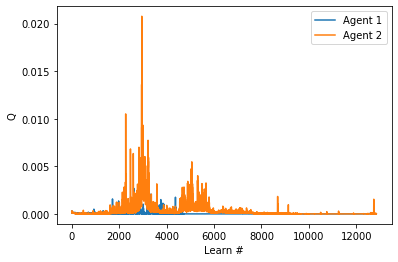

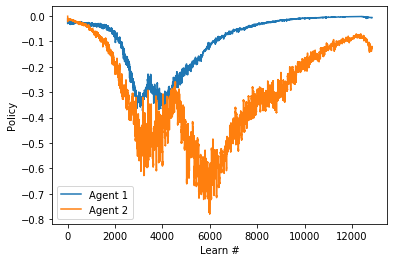

Episode 4800(6sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4800	Average Score: -0.00	Timestep: 71707

Batch Size: 16384


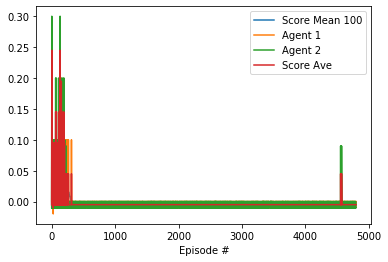

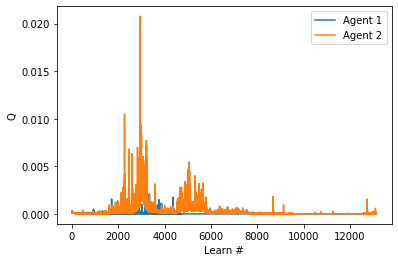

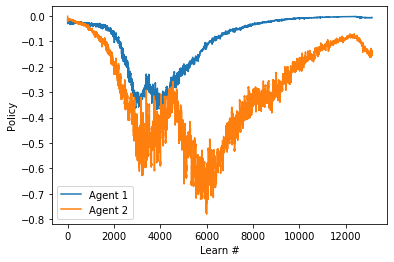

Episode 4900(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 4900	Average Score: -0.00	Timestep: 73139

Batch Size: 16384


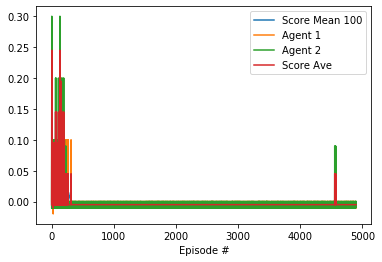

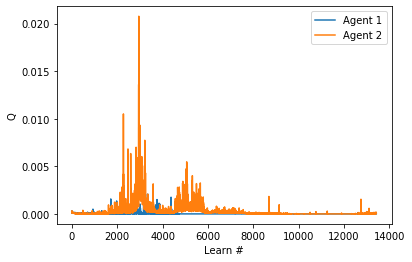

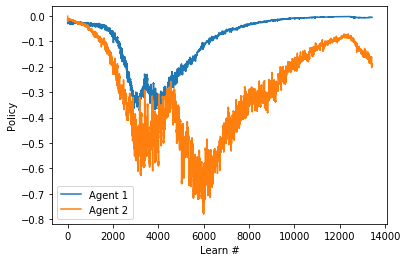

Episode 5000(0sec)	 MIN:-0.01 MAX:0.00 MEAN:-0.00 MEANo100:-0.00
Episode 5000	Average Score: -0.00	Timestep: 74577

Batch Size: 16384


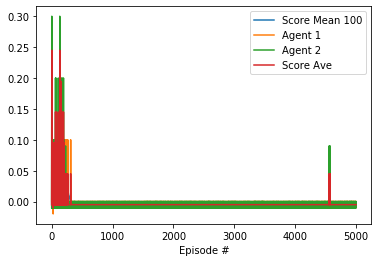

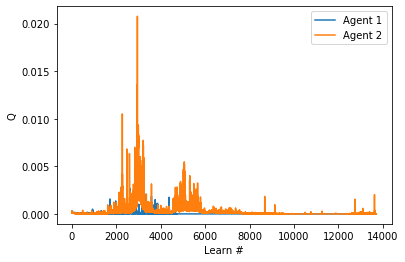

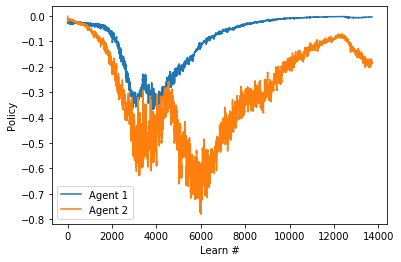

In [419]:
# benchmark
BUFFER_SIZE = 2 ** 14  # replay buffer size
BATCH_SIZE = 1000         # minibatch size
GAMMA = 0.95            # discount factor
TAU_ACTOR = 1e-2              # for soft update of target parameters
TAU_CRITIC = 1e-2              # for soft update of target parameters
LR_ACTOR = 1e-3         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
LEARN_EVERY = 50        # learning timestep interval
LEARN_NUM = 10          # number of learning passes
LEARN_AFTER = 6000
SEED=1

# read model weights
best_agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
actor_state_dict_0 = torch.load('./experiment_2/actor0_1600.pth', map_location='cpu')
actor_state_dict_1 = torch.load('./experiment_2/actor1_3000.pth', map_location='cpu')
best_agent.actor_local[0].load_state_dict(actor_state_dict_0)
best_agent.actor_local[1].load_state_dict(actor_state_dict_1)
best_agent.actor_target[0].load_state_dict(actor_state_dict_0)
best_agent.actor_target[1].load_state_dict(actor_state_dict_1)

scores_ave, agent = train(n_episodes=5000, random_seed=SEED, agent=best_agent)

In [423]:
# read model weights
best_agent = Agent(state_size=state_size, action_size=action_size, random_seed=1, num_agents=num_agents)
actor_state_dict_0 = torch.load('./experiment_3/actor0_4600.pth', map_location='cpu')
actor_state_dict_1 = torch.load('./experiment_3/actor1_4600.pth', map_location='cpu')
best_agent.actor_local[0].load_state_dict(actor_state_dict_0)
best_agent.actor_local[1].load_state_dict(actor_state_dict_1)

play(best_agent)

Score (sum over agents) from episode 0: -0.01
Score (sum over agents) from episode 1: -0.01
Score (sum over agents) from episode 2: -0.01
Score (sum over agents) from episode 3: -0.01
Score (sum over agents) from episode 4: -0.01
Score (sum over agents) from episode 5: -0.01
Score (sum over agents) from episode 6: -0.01
Score (sum over agents) from episode 7: -0.01
Score (sum over agents) from episode 8: -0.01
Score (sum over agents) from episode 9: -0.01


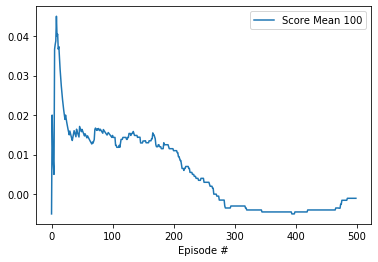

In [347]:
fig, ax = plt.subplots()

plt.plot(np.arange(len(scores_ave)), scores_ave, label='Score Mean 100')
plt.xlabel('Episode #')

ax.legend()
plt.show()


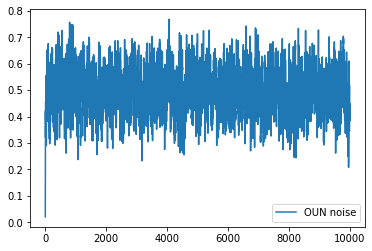

In [20]:
# To test OUNoise hyperparameters
oun = OUNoise(size=1, seed=1, mu=-0., theta=0.15, sigma=0.15)
cnt = 10000
result = []
for _ in range(cnt):
    r = oun.sample()
    result.append(r)

fig, ax = plt.subplots()
plt.plot(np.arange(cnt), result, label='OUN noise')

ax.legend()
plt.show()

In [292]:
# test noise
test_agent = Agent(state_size=state_size, action_size=action_size, 
                   num_agents=num_agents, random_seed=1)

for i in range(20):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    test_agent.reset()
    while True:
        actions = test_agent.act(states, add_noise=True)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 0: 0.0
Score (max over agents) from episode 1: 0.10000000149011612
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 0.0
Score (max over agents) from episode 6: 0.0
Score (max over agents) from episode 7: 0.10000000149011612
Score (max over agents) from episode 8: 0.10000000149011612
Score (max over agents) from episode 9: 0.10000000149011612
Score (max over agents) from episode 10: 0.10000000149011612
Score (max over agents) from episode 11: 0.10000000149011612
Score (max over agents) from episode 12: 0.0
Score (max over agents) from episode 13: 0.0
Score (max over agents) from episode 14: 0.0
Score (max over agents) from episode 15: 0.10000000149011612
Score (max over agents) from episode 16: 0.0
Score (max over agents) from episode 17: 0.0
Score (max over agents) from episode 18:

In [424]:
env.close()